<a href="https://colab.research.google.com/github/siddharth-chakravarthula/TNBC/blob/main/tnbc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Goal: Predict the time until cancer recurrence and death for TNBC patients using clinical data.**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sidtheimmortalgod","key":"e3dd366b6aa3e0f28313c6593a04ada1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gunesevitan/breast-cancer-metabric

Dataset URL: https://www.kaggle.com/datasets/gunesevitan/breast-cancer-metabric
License(s): ODbL-1.0
  0% 0.00/77.2k [00:00<?, ?B/s]
100% 77.2k/77.2k [00:00<00:00, 50.1MB/s]


In [ ]:
!unzip breast-cancer-metabric.zip

Archive:  breast-cancer-metabric.zip
  inflating: Breast Cancer METABRIC.csv  


In [ ]:
import pandas as pd
df = pd.read_csv("/content/Breast Cancer METABRIC.csv")
df.head(), df.columns, len(df)

(  Patient ID  Age at Diagnosis Type of Breast Surgery    Cancer Type  \
 0    MB-0000             75.65             Mastectomy  Breast Cancer   
 1    MB-0002             43.19      Breast Conserving  Breast Cancer   
 2    MB-0005             48.87             Mastectomy  Breast Cancer   
 3    MB-0006             47.68             Mastectomy  Breast Cancer   
 4    MB-0008             76.97             Mastectomy  Breast Cancer   
 
                         Cancer Type Detailed Cellularity Chemotherapy  \
 0           Breast Invasive Ductal Carcinoma         NaN           No   
 1           Breast Invasive Ductal Carcinoma        High           No   
 2           Breast Invasive Ductal Carcinoma        High          Yes   
 3  Breast Mixed Ductal and Lobular Carcinoma    Moderate          Yes   
 4  Breast Mixed Ductal and Lobular Carcinoma        High          Yes   
 
   Pam50 + Claudin-low subtype  Cohort ER status measured by IHC  ...  \
 0                 claudin-low     1.0   

### Data Preprocessing

Handling Missing Values

In [ ]:
# Find the amount of missing values in each column.
missing_values = df.isnull().mean() * 100
print(missing_values)

Patient ID                         0.000000
Age at Diagnosis                   0.438422
Type of Breast Surgery            22.080510
Cancer Type                        0.000000
Cancer Type Detailed               0.000000
Cellularity                       23.595058
Chemotherapy                      21.084097
Pam50 + Claudin-low subtype       21.084097
Cohort                             0.438422
ER status measured by IHC          3.308091
ER Status                          1.594261
Neoplasm Histologic Grade          4.822639
HER2 status measured by SNP6      21.084097
HER2 Status                       21.084097
Tumor Other Histologic Subtype     5.380630
Hormone Therapy                   21.084097
Inferred Menopausal State         21.084097
Integrative Cluster               21.084097
Primary Tumor Laterality          25.468314
Lymph nodes examined positive     10.601833
Mutation Count                     6.058191
Nottingham prognostic index        8.848147
Oncotree Code                   

In [ ]:
# Mode imputation for categorical columns to fill in the empty values.
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for categorical_column in categorical_columns:
    df[categorical_column] = df[categorical_column].fillna(df[categorical_column].mode()[0])

In [ ]:
# Mean or median imputation for numerical columns to fill in the empty values.
numerical_columns = df.select_dtypes(include=['number']).columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

In [ ]:
# Filter TNBC data.
tnbc_df = df[(df['ER Status'] == 'Negative') & (df['PR Status'] == 'Negative') & (df['HER2 Status'] == 'Negative')]
tnbc_df.head(), tnbc_df.columns

(   Patient ID  Age at Diagnosis Type of Breast Surgery    Cancer Type  \
 7     MB-0020             70.00             Mastectomy  Breast Cancer   
 23    MB-0062             52.14             Mastectomy  Breast Cancer   
 28    MB-0079             50.42             Mastectomy  Breast Cancer   
 35    MB-0100             68.68             Mastectomy  Breast Cancer   
 42    MB-0110             45.73      Breast Conserving  Breast Cancer   
 
                  Cancer Type Detailed Cellularity Chemotherapy  \
 7   Breast Invasive Lobular Carcinoma        High          Yes   
 23   Breast Invasive Ductal Carcinoma        High          Yes   
 28   Breast Invasive Ductal Carcinoma        High          Yes   
 35   Breast Invasive Ductal Carcinoma         Low          Yes   
 42          Invasive Breast Carcinoma         Low           No   
 
    Pam50 + Claudin-low subtype  Cohort ER status measured by IHC  ...  \
 7                       Normal     1.0                  Negative  ...   
 2

In [ ]:
# One-hot encoding categorical columns...
# Select categorical columns
cat_cols = tnbc_df.select_dtypes(include=['object', 'category']).columns

# Perform one-hot encoding using pandas get_dummies, drop_first=True to avoid the dummy variable trap
tnbc_df = pd.get_dummies(tnbc_df, columns=cat_cols, drop_first=True)

# Convert Boolean Values to Numerical Ones
bool_cols = tnbc_df.select_dtypes(include=['bool']).columns
for col in bool_cols:
    tnbc_df[col] = tnbc_df[col].astype(int)

In [ ]:
# Normalize the Data
from sklearn.preprocessing import MinMaxScaler
features_to_scale = [numerical_columns[i] for i in range(len(numerical_columns))]
scaler = MinMaxScaler()
tnbc_df[features_to_scale] = scaler.fit_transform(tnbc_df[features_to_scale])
tnbc_df.head()

,Age at Diagnosis,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Relapse Free Status (Months),Tumor Size,Tumor Stage,...,Oncotree Code_MDLC,Oncotree Code_PBS,Overall Survival Status_Living,Radio Therapy_Yes,Relapse Free Status_Recurred,3-Gene classifier subtype_ER+/HER2- Low Prolif,3-Gene classifier subtype_ER-/HER2-,3-Gene classifier subtype_HER2+,Patient's Vital Status_Died of Other Causes,Patient's Vital Status_Living
7,0.622107,0.0,1.00000,0.088660,0.117403,0.964286,0.072743,0.038634,0.353591,1.000000,...,0,0,0,1,1,0,1,0,0,0
23,0.365387,0.0,1.00000,0.000000,0.051282,0.570301,0.500000,0.500000,0.088398,0.333333,...,0,0,1,1,0,1,0,0,0,1
28,0.340664,0.0,1.00000,0.181818,0.076923,0.954887,0.092553,0.086482,0.215470,0.666667,...,0,0,0,1,1,1,0,0,0,0
35,0.603134,0.0,1.00000,0.000000,0.000000,0.578571,0.026196,0.025767,0.209945,0.666667,...,0,0,0,1,1,0,1,0,0,0
42,0.273250,0.0,0.70603,0.088660,0.117403,0.214286,0.511474,0.040049,0.381215,0.000000,...,0,0,1,0,1,1,0,0,0,1


In [ ]:
import numpy as np
# Create general event indicator
tnbc_df['Event'] = np.where(
    (tnbc_df['Relapse Free Status_Recurred'] == 1) | (tnbc_df['Overall Survival Status_Living'] == 0),
    1, # If the events occurred
    0  # If the events did not occur
)

# Create general time-to-event column
tnbc_df['Time-To-Event'] = np.minimum(tnbc_df['Relapse Free Status (Months)'], tnbc_df['Overall Survival (Months)'])

tnbc_df.head()

<ipython-input-14-3db2e1c52ce2>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tnbc_df['Event'] = np.where(
<ipython-input-14-3db2e1c52ce2>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tnbc_df['Time-To-Event'] = np.minimum(tnbc_df['Relapse Free Status (Months)'], tnbc_df['Overall Survival (Months)'])


,Age at Diagnosis,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Relapse Free Status (Months),Tumor Size,Tumor Stage,...,Overall Survival Status_Living,Radio Therapy_Yes,Relapse Free Status_Recurred,3-Gene classifier subtype_ER+/HER2- Low Prolif,3-Gene classifier subtype_ER-/HER2-,3-Gene classifier subtype_HER2+,Patient's Vital Status_Died of Other Causes,Patient's Vital Status_Living,Event,Time-To-Event
7,0.622107,0.0,1.00000,0.088660,0.117403,0.964286,0.072743,0.038634,0.353591,1.000000,...,0,1,1,0,1,0,0,0,1,0.038634
23,0.365387,0.0,1.00000,0.000000,0.051282,0.570301,0.500000,0.500000,0.088398,0.333333,...,1,1,0,1,0,0,0,1,0,0.500000
28,0.340664,0.0,1.00000,0.181818,0.076923,0.954887,0.092553,0.086482,0.215470,0.666667,...,0,1,1,1,0,0,0,0,1,0.086482
35,0.603134,0.0,1.00000,0.000000,0.000000,0.578571,0.026196,0.025767,0.209945,0.666667,...,0,1,1,0,1,0,0,0,1,0.025767
42,0.273250,0.0,0.70603,0.088660,0.117403,0.214286,0.511474,0.040049,0.381215,0.000000,...,1,0,1,1,0,0,0,1,1,0.040049


### Exploratory Data Analysis

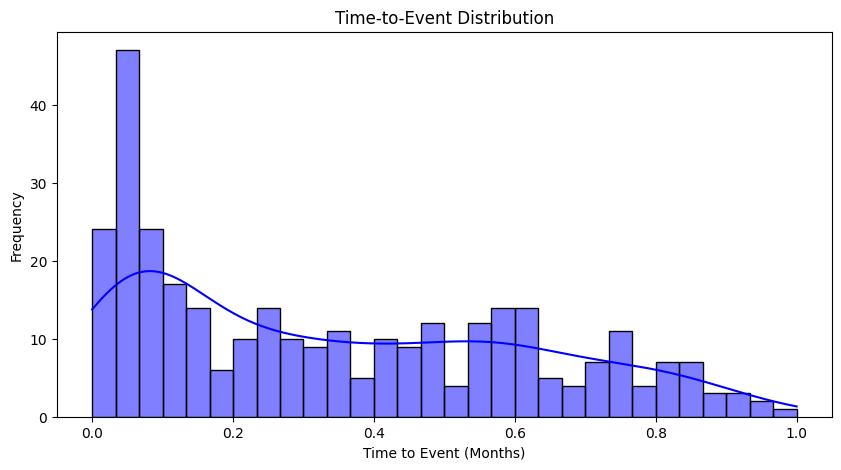

<ipython-input-15-c2f9dae03be5>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=tnbc_df['Event'], palette="viridis")


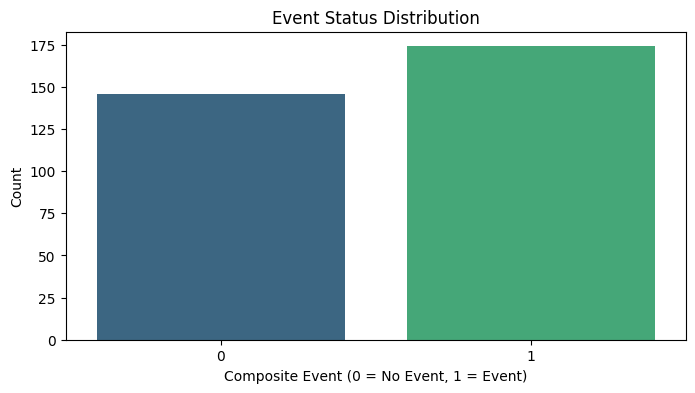

In [ ]:
# Some histograms to get a feel for the data
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram for time-to-event
plt.figure(figsize=(10, 5))
sns.histplot(tnbc_df['Time-To-Event'], bins=30, kde=True, color='blue')
plt.title("Time-to-Event Distribution")
plt.xlabel("Time to Event (Months)")
plt.ylabel("Frequency")
plt.show()

# Plot bar chart for composite_event
plt.figure(figsize=(8, 4))
sns.countplot(x=tnbc_df['Event'], palette="viridis")
plt.title("Event Status Distribution")
plt.xlabel("Composite Event (0 = No Event, 1 = Event)")
plt.ylabel("Count")
plt.show()

In [ ]:
# Feature Importance Analysis

# Univariate Cox Regression
!pip install lifelines
from lifelines import CoxPHFitter, exceptions
import pandas as pd

# Specify the target column and covariates
target_columns = ['Time-To-Event', 'Event']
# Exclude target columns AND patient ID columns
patientIdColumns = ['Patient ID']
covariates = [col for col in tnbc_df.columns if col not in target_columns and col not in patientIdColumns]

# Initialize and fit CoxPHFitter
cph = CoxPHFitter()

significant_features = []
for covariate in covariates:
    model_data = tnbc_df[target_columns + [covariate]]

    # Add a try-except block to handle ConvergenceError
    try:
        cph.fit(model_data, duration_col='Time-To-Event', event_col='Event', show_progress=True)  # show_progress for debugging

        p_value = cph.summary['p'][0]
        hazard_ratio = cph.summary['exp(coef)'][0]

        if p_value < 0.05:  # Check for statistical significance
            significant_features.append((covariate, p_value, hazard_ratio))
            print(f"{covariate}:")
            print(f"  - p-value: {p_value:.3f} (Statistically significant)")
            print(f"  - Hazard Ratio: {hazard_ratio:.3f}")
            if hazard_ratio > 1:
                print(f"  - Interpretation: Increased risk of event as {covariate} increases.")
            else:
                print(f"  - Interpretation: Decreased risk of event as {covariate} increases.")
            print("-" * 20)

    except exceptions.ConvergenceError: # Use exceptions from lifelines to handle errors
        print(f"ConvergenceError for {covariate}. Skipping this feature.")

print("Summary of Significant Features:")
for feature, p_value, hazard_ratio in significant_features:
    print(f"{feature}: p-value = {p_value:.3f}, Hazard Ratio = {hazard_ratio:.3f}")

# Research more about the implications of the findings...

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=7958b2490ea7a131697e2b39d67f0a5387820df3f9d7aa37cc68a4f101a46d46
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Iteration 1: norm_delta = 2.35e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.43e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.33e-02, step_size = 0.9500, log_lik = -903.02450, newton_decrement = 1.40e-02, seconds_since_start = 0.1
Iteration 3: norm_delta = 6.79e-04, step_size = 0.9500, log_lik = -903.01057, newton_decrement = 3.62e-05, seconds_since_start = 0.1
Iteration 4: norm_delta = 3.55e-08, step_size = 1.0000, log_lik = -903.01053, newton_decrement

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 1.77e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.43e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.22e-04, step_size = 0.9500, log_lik = -907.42763, newton_decrement = 6.60e-05, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.62e-05, step_size = 0.9500, log_lik = -907.42756, newton_decrement = 1.66e-07, seconds_since_start = 0.1
Iteration 4: norm_delta = 2.78e-10, step_size = 1.0000, log_lik = -907.42756, newton_decrement = 5.98e-18, seconds_since_start = 0.1
Convergence success after 4 iterations.


<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 8.20e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.45e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.27e-02, step_size = 0.9500, log_lik = -906.77527, newton_decrement = 1.29e-02, seconds_since_start = 0.1
Iteration 3: norm_delta = 8.20e-04, step_size = 0.9500, log_lik = -906.76231, newton_decrement = 5.26e-05, seconds_since_start = 0.1
Iteration 4: norm_delta = 7.75e-07, step_size = 1.0000, log_lik = -906.76226, newton_decrement = 4.69e-11, seconds_since_start = 0.1
Convergence success after 4 iterations.


<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]


Iteration 1: norm_delta = 8.56e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.12e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.87e-01, step_size = 0.9500, log_lik = -907.94935, newton_decrement = 1.81e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.46e-02, step_size = 0.9500, log_lik = -888.50473, newton_decrement = 8.50e-01, seconds_since_start = 0.1
Iteration 4: norm_delta = 6.01e-03, step_size = 1.0000, log_lik = -887.61548, newton_decrement = 4.76e-03, seconds_since_start = 0.1
Iteration 5: norm_delta = 3.85e-05, step_size = 1.0000, log_lik = -887.61070, newton_decrement = 1.93e-07, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.58e-09, step_size = 1.0000, log_lik = -887.61070, newton_decrement = 3.24e-16, seconds_since_start = 0.1
Convergence success after 6 iterations.


<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Lymph nodes examined positive:
  - p-value: 0.000 (Statistically significant)
  - Hazard Ratio: 12.708
  - Interpretation: Increased risk of event as Lymph nodes examined positive increases.
--------------------
Iteration 1: norm_delta = 2.78e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.80e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.87e-03, step_size = 0.9500, log_lik = -907.35139, newton_decrement = 9.54e-04, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.59e-04, step_size = 0.9500, log_lik = -907.35044, newton_decrement = 2.88e-06, seconds_since_start = 0.1
Iteration 4: norm_delta = 4.51e-08, step_size = 1.0000, log_lik = -907.35044, newton_decrement = 2.33e-13, seconds_since_start = 0.2
Convergence success after 4 iterations.


<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]


Iteration 1: norm_delta = 3.58e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.92e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.04e-02, step_size = 0.9500, log_lik = -896.96630, newton_decrement = 2.34e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.84e-03, step_size = 0.9500, log_lik = -896.73133, newton_decrement = 9.22e-04, seconds_since_start = 0.1
Iteration 4: norm_delta = 3.16e-06, step_size = 1.0000, log_lik = -896.73040, newton_decrement = 6.22e-10, seconds_since_start = 0.1
Convergence success after 4 iterations.
Nottingham prognostic index:
  - p-value: 0.000 (Statistically significant)
  - Hazard Ratio: 7.547
  - Interpretation: Increased risk of event as Nottingham prognostic index increases.
--------------------


<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 1.55e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.40e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.42e+00, step_size = 0.9500, log_lik = -742.12061, newton_decrement = 4.49e+01, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.56e+00, step_size = 0.9500, log_lik = -686.17833, newton_decrement = 2.01e+01, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.17e+00, step_size = 0.9310, log_lik = -662.27478, newton_decrement = 5.38e+00, seconds_since_start = 0.1
Iteration 5: norm_delta = 4.45e-01, step_size = 0.9124, log_lik = -656.36726, newton_decrement = 5.21e-01, seconds_since_start = 0.1
Iteration 6: norm_delta = 3.59e-02, step_size = 1.0000, log_lik = -655.82170, newton_decrement = 2.94e-03, seconds_since_start = 0.2
Iteration 7: norm_delta = 2.02e-04, step_size = 1.0000, log_lik = -655.81876, newton_decrement = 9.25e-08, seconds_since_start = 0.2
Convergence success after 7 iterations.


<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Overall Survival (Months):
  - p-value: 0.000 (Statistically significant)
  - Hazard Ratio: 0.000
  - Interpretation: Decreased risk of event as Overall Survival (Months) increases.
--------------------
Iteration 1: norm_delta = 1.69e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.65e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.01e+00, step_size = 0.9500, log_lik = -707.77687, newton_decrement = 7.60e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.72e+00, step_size = 0.9500, log_lik = -607.70140, newton_decrement = 6.99e+01, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.48e+00, step_size = 0.9310, log_lik = -515.29011, newton_decrement = 7.37e+01, seconds_since_start = 0.1
Iteration 5: norm_delta = 9.30e+00, step_size = 0.2281, log_lik = -485.00368, newton_decrement = 7.47e+01, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.00e+01, step_size = 0.0726, log_lik = -474.52439, newton_decrement = 7.49e+01, seconds_since_start = 0.1

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column Relapse Free Status (Months) has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

Iteration 5: norm_delta = 3.50e-06, step_size = 1.0000, log_lik = -903.46498, newton_decrement = 2.14e-09, seconds_since_start = 0.1
Convergence success after 5 iterations.
Tumor Size:
  - p-value: 0.001 (Statistically significant)
  - Hazard Ratio: 5.629
  - Interpretation: Increased risk of event as Tumor Size increases.
--------------------
Iteration 1: norm_delta = 2.79e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.38e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.31e-02, step_size = 0.9500, log_lik = -901.09122, newton_decrement = 1.43e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 6.44e-04, step_size = 0.9500, log_lik = -901.07696, newton_decrement = 3.46e-05, seconds_since_start = 0.1
Iteration 4: norm_delta = 2.93e-08, step_size = 1.0000, log_lik = -901.07693, newton_decrement = 7.13e-14, seconds_since_start = 0.1
Convergence success after 4 iterations.


<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Tumor Stage:
  - p-value: 0.000 (Statistically significant)
  - Hazard Ratio: 4.502
  - Interpretation: Increased risk of event as Tumor Stage increases.
--------------------
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.60e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01042, newton_decrement = 1.39e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84044, newton_decrement = 5.35e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.77280, newton_decrement = 1.97e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74794, newton_decrement = 7.23e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.73879, newton_decrement = 2.66e-03, seconds_since_start = 0.2
Iteration 7: norm_delta = 5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 2: norm_delta = 3.64e-02, step_size = 0.9500, log_lik = -907.67191, newton_decrement = 5.56e-01, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.84e-02, step_size = 0.9500, log_lik = -907.03249, newton_decrement = 7.90e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 3.65e-03, step_size = 1.0000, log_lik = -906.94578, newton_decrement = 2.25e-03, seconds_since_start = 0.1
Iteration 5: norm_delta = 1.21e-04, step_size = 1.0000, log_lik = -906.94348, newton_decrement = 2.32e-06, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.28e-07, step_size = 1.0000, log_lik = -906.94348, newton_decrement = 2.59e-12, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 1.40e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.21e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.82e+06, step_size = 0.9500, log_lik = -1101.07652, newton_decrement = 3.76e+08, seconds_since_start = 0.0
ConvergenceError for Patient

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxp

Iteration 1: norm_delta = 4.56e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.63e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.73e-01, step_size = 0.9500, log_lik = -971.18806, newton_decrement = 1.19e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 6.18e-01, step_size = 0.9500, log_lik = -907.70199, newton_decrement = 5.07e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.12e+00, step_size = 0.9310, log_lik = -1040.23672, newton_decrement = 1.16e+03, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.58e+15, step_size = 0.9124, log_lik = -964.50344, newton_decrement = 2.31e+16, seconds_since_start = 0.1
ConvergenceError for Patient ID_MB-0110. Skipping this feature.
Iteration 1: norm_delta = 1.07e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.30e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.98e-02, step_size = 0.9500, log_lik = -907.39391, newton_decrement = 2.89e-01, seconds_since_start = 0.0
Iter

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.46e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.02742, newton_decrement = 1.33e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.86397, newton_decrement = 5.15e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.79892, newton_decrement = 1.89e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.77500, newton_decrement = 6.96e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76621, newton_decrement = 2.56e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76297, newton_decrement = 9.41e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 6.36e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.02e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.53e-02, step_size = 0.9500, log_lik = -907.28033, newton_decrement = 5.07e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.18e-03, step_size = 0.9500, log_lik = -907.22608, newton_decrement = 1.70e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 9.23e-05, step_size = 1.0000, log_lik = -907.22435, newton_decrement = 1.35e-06, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.49e-08, step_size = 1.0000, log_lik = -907.22435, newton_decrement = 8.90e-13, seconds_since_start = 0.1
Convergence success after 5 iterations.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.26e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.05222, newton_decrement = 1.26e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.89828, newton_decrement = 4.85e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.83702, newton_decrement = 1.78e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81449, newton_decrement = 6.55e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80621, newton_decrement = 2.41e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80316, newton_decrement = 8.87e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 3.86e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.41e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.82e-03, step_size = 0.9500, log_lik = -907.34402, newton_decrement = 8.40e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.81e-04, step_size = 0.9500, log_lik = -907.33536, newton_decrement = 9.82e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.42e-06, step_size = 1.0000, log_lik = -907.33526, newton_decrement = 4.67e-09, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.10e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.40165, newton_decrement = 1.58e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.38226, newton_decrement = 6.11e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.37013, newton_decrement = 4.11e-05, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.37008, newton_decrement = 1.51e-05, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.37006, newton_decrement = 5.56e-06, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.37006, newton_decrement = 2.05e-06, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.37005, newton_decrement = 7.53e-07, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.37005, newton_decrement = 2.77e-07, seconds_since_start = 0.2
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.37005, newton_decrement = 1.02e-07, seconds_since_start = 0.2
Convergence success after 14 iterations.
Iteration 1: norm_delta

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.92673, newton_decrement = 5.40e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91990, newton_decrement = 1.99e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91739, newton_decrement = 7.31e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91646, newton_decrement = 2.69e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91612, newton_decrement = 9.89e-05, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91600, newton_decrement = 3.64e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91595, newton_decrement = 1.34e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 2.65e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.95e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.71e-02, step_size = 0.9500, log_lik = -916.52038, newton_decrement = 6.63e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.80e-02, step_size = 0.9500, log_lik = -908.72523, newton_decrement = 1.54e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.98e-02, step_size = 1.0000, log_lik = -906.86895, newton_decrement = 2.80e-01, seconds_since_start = 0.1
Iteration 5: norm_delta = 1.04e-02, step_size = 1.0000, log_lik = -906.54846, newton_decrement = 2.07e-02, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.04e-03, step_size = 1.0000, log_lik = -906.52661, newton_decrement = 1.74e-04, seconds_since_start = 0.1
Iteration 7: norm_delta = 9.45e-06, step_size = 1.0000, log_lik = -906.52644, newton_decrement = 1.40e-08, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 3.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 8: norm_delta = 1.55e-08, step_size = 1.0000, log_lik = -906.34676, newton_decrement = 3.74e-14, seconds_since_start = 0.1
Convergence success after 8 iterations.
Iteration 1: norm_delta = 2.53e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.05e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.05e-03, step_size = 0.9500, log_lik = -907.39172, newton_decrement = 1.56e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.37e-04, step_size = 0.9500, log_lik = -907.39014, newton_decrement = 8.97e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.97e-07, step_size = 1.0000, log_lik = -907.39013, newton_decrement = 3.93e-11, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0


<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74433, newton_decrement = 3.55e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]


Iteration 4: norm_delta = 2.82e-04, step_size = 1.0000, log_lik = -907.16088, newton_decrement = 1.26e-05, seconds_since_start = 0.1
Iteration 5: norm_delta = 6.99e-07, step_size = 1.0000, log_lik = -907.16087, newton_decrement = 7.75e-11, seconds_since_start = 0.1
Convergence success after 5 iterations.


<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.1
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.2
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.2
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.2
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 8.96e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.93e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.42e-02, step_size = 0.9500, log_lik = -907.30032, newton_decrement = 1.61e-01, seconds_since_start = 0.1
Iteration 3: norm_delta = 7.83e-03, step_size = 0.9500, log_lik = -907.12236, newton_decrement = 1.13e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 5.89e-04, step_size = 1.0000, log_lik = -907.11059, newton_decrement = 5.54e-05, seconds_since_start = 0.1
Iteration 5: norm_delta = 3.06e-06, step_size = 1.0000, log_lik = -907.11054, newton_decrement = 1.48e-09, seconds_since_start = 0.2
Convergence success after 5 iterations.


<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 1.85e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.27e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.84e-02, step_size = 0.9500, log_lik = -909.26401, newton_decrement = 1.72e+00, seconds_since_start = 0.1
Iteration 3: norm_delta = 3.26e-02, step_size = 0.9500, log_lik = -907.23152, newton_decrement = 3.76e-01, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.31e-02, step_size = 1.0000, log_lik = -906.79534, newton_decrement = 3.47e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 1.71e-03, step_size = 1.0000, log_lik = -906.75816, newton_decrement = 4.76e-04, seconds_since_start = 0.1
Iteration 6: norm_delta = 2.59e-05, step_size = 1.0000, log_lik = -906.75768, newton_decrement = 1.06e-07, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.81e-09, step_size = 1.0000, log_lik = -906.75768, newton_decrement = 5.33e-15, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.74874, newton_decrement = 6.15e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.67103, newton_decrement = 2.26e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64246, newton_decrement = 8.31e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.63196, newton_decrement = 3.06e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62809, newton_decrement = 1.12e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62667, newton_decrement = 4.14e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62615, newton_decrement = 1.52e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.14e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.94409, newton_decrement = 1.59e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.74874, newton_decrement = 6.15e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.67103, newton_decrement = 2.26e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64246, newton_decrement = 8.31e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.63196, newton_decrement = 3.06e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62809, newton_decrement = 1.12e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxp

Iteration 2: norm_delta = 1.10e+00, step_size = 0.9500, log_lik = -989.15390, newton_decrement = 2.71e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.27e+04, step_size = 0.9500, log_lik = -917.37739, newton_decrement = 1.14e+05, seconds_since_start = 0.1
ConvergenceError for Patient ID_MB-0259. Skipping this feature.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.14e-01, seconds_since_start = 0.0


/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Patient ID_MB-0259 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Patient ID_MB-0259'].var())
>>> print(df.loc[~events, 'Patient ID_MB-0259'].var())

A very low variance means that the column Patient ID_MB-0259 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.94409, newton_decrement = 1.59e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.74874, newton_decrement = 6.15e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.67103, newton_decrement = 2.26e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64246, newton_decrement = 8.31e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.63196, newton_decrement = 3.06e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62809, newton_decrement = 1.12e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62667, newton_decrement = 4.14e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.20306, newton_decrement = 3.41e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.20263, newton_decrement = 1.25e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.20247, newton_decrement = 4.61e-05, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.20242, newton_decrement = 1.70e-05, seconds_since_start = 0.2
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.20239, newton_decrement = 6.24e-06, seconds_since_start = 0.2
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.20239, newton_decrement = 2.29e-06, seconds_since_start = 0.2
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.20238, newton_decrement = 8.44e-07, seconds_since_start = 0.2
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Patient ID_MB-0278 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Patient ID_MB-0278']

Iteration 1: norm_delta = 2.47e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.16e+01, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-0278. Skipping this feature.
ConvergenceError for Patient ID_MB-0284. Skipping this feature.
Iteration 1: norm_delta = 5.23e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.26e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.14e-02, step_size = 0.9500, log_lik = -907.30232, newton_decrement = 2.56e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.85e-03, step_size = 0.9500, log_lik = -907.27543, newton_decrement = 5.59e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.06e-05, step_size = 1.0000, log_lik = -907.27487, newton_decrement = 1.49e-07, seconds_since_start = 0.0
Iteration 5: norm_delta = 8.26e-09, step_size = 1.0000, log_lik = -907.27487, newton_decrement = 1.08e-14, seconds_since_start = 0.1
Convergence success after 5 iterations.


<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 6.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.21e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.62e-02, step_size = 0.9500, log_lik = -907.27734, newton_decrement = 5.85e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.56e-03, step_size = 0.9500, log_lik = -907.21458, newton_decrement = 2.15e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.16e-04, step_size = 1.0000, log_lik = -907.21239, newton_decrement = 2.14e-06, seconds_since_start = 0.1
Iteration 5: norm_delta = 1.19e-07, step_size = 1.0000, log_lik = -907.21239, newton_decrement = 2.23e-12, seconds_since_start = 0.1
Convergence success after 5 iterations.
Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.60e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.13326, newton_decrement = 1.00e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.14e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.94409, newton_decrement = 1.59e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.74874, newton_decrement = 6.15e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.67103, newton_decrement = 2.26e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64246, newton_decrement = 8.31e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.63196, newton_decrement = 3.06e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62809, newton_decrement = 1.12e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.16014, newton_decrement = 9.17e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.04770, newton_decrement = 3.54e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.00294, newton_decrement = 1.30e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.98649, newton_decrement = 4.79e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.98044, newton_decrement = 1.76e-03, seconds_since_start = 0.2
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.97821, newton_decrement = 6.48e-04, seconds_since_start = 0.2
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.97739, newton_decrement = 2.38e-04, seconds_since_start = 0.2
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.07e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.95352, newton_decrement = 1.56e-01, seconds_since_start = 0.1
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.76176, newton_decrement = 6.03e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.68547, newton_decrement = 2.22e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65743, newton_decrement = 8.16e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64711, newton_decrement = 3.00e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64332, newton_decrement = 1.10e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.76e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.99107, newton_decrement = 1.45e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.81368, newton_decrement = 5.58e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74310, newton_decrement = 2.05e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.71715, newton_decrement = 7.55e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70761, newton_decrement = 2.78e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70410, newton_decrement = 1.02e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 7.49e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.83e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.92e-02, step_size = 0.9500, log_lik = -907.27479, newton_decrement = 8.85e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.94e-03, step_size = 0.9500, log_lik = -907.17869, newton_decrement = 4.24e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.27e-04, step_size = 1.0000, log_lik = -907.17434, newton_decrement = 8.19e-06, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.53e-07, step_size = 1.0000, log_lik = -907.17433, newton_decrement = 3.25e-11, seconds_since_start = 0.0
Convergence success after 5 iterations.
Iteration 1: norm_delta = 7.34e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.72e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.87e-02, step_size = 0.9500, log_lik = -907.27441, newton_decrement = 8.27e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

ConvergenceError for Patient ID_MB-0354. Skipping this feature.
Iteration 1: norm_delta = 7.19e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.61e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.82e-02, step_size = 0.9500, log_lik = -907.27438, newton_decrement = 7.72e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.44e-03, step_size = 0.9500, log_lik = -907.19086, newton_decrement = 3.39e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.82e-04, step_size = 1.0000, log_lik = -907.18739, newton_decrement = 5.27e-06, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.92e-07, step_size = 1.0000, log_lik = -907.18738, newton_decrement = 1.35e-11, seconds_since_start = 0.0
Convergence success after 5 iterations.
Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.38e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.16014, newton_decrement = 9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]


Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.97694, newton_decrement = 1.19e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.97692, newton_decrement = 4.37e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.97692, newton_decrement = 1.61e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.97691, newton_decrement = 5.91e-07, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.97691, newton_decrement = 2.17e-07, seconds_since_start = 0.2
Convergence success after 15 iterations.
Iteration 1: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.50e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.26e-02, step_size = 0.9500, log_lik = -907.29380, newton_decrement = 3.24e-02, seconds_since_start = 0.0
Iteration 3: norm_delta

<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ trea

Iteration 1: norm_delta = 2.33e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.68e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.85e-02, step_size = 0.9500, log_lik = -912.70346, newton_decrement = 4.01e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.29e-02, step_size = 0.9500, log_lik = -907.95612, newton_decrement = 9.78e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.39e-02, step_size = 1.0000, log_lik = -906.78830, newton_decrement = 1.51e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 6.36e-03, step_size = 1.0000, log_lik = -906.61894, newton_decrement = 7.13e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 3.74e-04, step_size = 1.0000, log_lik = -906.61156, newton_decrement = 2.21e-05, seconds_since_start = 0.0
Iteration 7: norm_delta = 1.21e-06, step_size = 1.0000, log_lik = -906.61153, newton_decrement = 2.30e-10, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 1.7

<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.69e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.12265, newton_decrement = 1.03e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.99579, newton_decrement = 3.99e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.94529, newton_decrement = 1.47e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.92673, newton_decrement = 5.40e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91990, newton_decrement = 1.99e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91739, newton_decrement = 7.31e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.10/dist-packages/lifelines/fitt

Iteration 1: norm_delta = 8.09e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.77e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.61e+02, step_size = 0.9500, log_lik = -1053.98773, newton_decrement = 2.74e+04, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.24e+16, step_size = 0.0950, log_lik = -1167.31616, newton_decrement = 1.11e+17, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-0424. Skipping this feature.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.11e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.07018, newton_decrement = 1.20e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.92315, newton_decrement = 4.63e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.86463, newton_decrement = 1.70e-02, seconds_since_start = 0.0
Ite

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81794, newton_decrement = 8.67e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81684, newton_decrement = 3.19e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81644, newton_decrement = 1.17e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81629, newton_decrement = 4.31e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81624, newton_decrement = 1.59e-05, seconds_since_start = 0.2
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81622, newton_decrement = 5.84e-06, seconds_since_start = 0.2
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81621, newton_decrement = 2.15e-06, seconds_since_start = 0.2
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 2: norm_delta = 1.06e-02, step_size = 0.9500, log_lik = -907.30851, newton_decrement = 2.17e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.62e-03, step_size = 0.9500, log_lik = -907.28577, newton_decrement = 4.30e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.36e-05, step_size = 1.0000, log_lik = -907.28533, newton_decrement = 8.84e-08, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.60e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.13326, newton_decrement = 1.00e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.01048, newton_decrement = 3.87e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.96161, newton_decrement = 1.42e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 7: norm_delta = 3.03e-05, step_size = 1.0000, log_lik = -906.45136, newton_decrement = 1.44e-07, seconds_since_start = 0.1
Iteration 8: norm_delta = 7.89e-09, step_size = 1.0000, log_lik = -906.45136, newton_decrement = 9.75e-15, seconds_since_start = 0.1
Convergence success after 8 iterations.
Iteration 1: norm_delta = 2.12e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.50e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.38e-02, step_size = 0.9500, log_lik = -910.88025, newton_decrement = 2.80e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.87e-02, step_size = 0.9500, log_lik = -907.56167, newton_decrement = 6.69e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.92e-02, step_size = 1.0000, log_lik = -906.77113, newton_decrement = 8.63e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 3.93e-03, step_size = 1.0000, log_lik = -906.67612, newton_decrement = 2.60e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.3

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.78e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.11128, newton_decrement = 1.07e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.98004, newton_decrement = 4.13e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.92780, newton_decrement = 1.52e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.90860, newton_decrement = 5.59e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.90153, newton_decrement = 2.06e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.89894, newton_decrement = 7.56e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.84e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.10344, newton_decrement = 1.09e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.96920, newton_decrement = 4.23e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91576, newton_decrement = 1.55e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.89612, newton_decrement = 5.72e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88889, newton_decrement = 2.10e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88623, newton_decrement = 7.73e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.93e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.34e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.01e-02, step_size = 0.9500, log_lik = -909.69585, newton_decrement = 2.01e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.46e-02, step_size = 0.9500, log_lik = -907.31491, newton_decrement = 4.56e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.50e-02, step_size = 1.0000, log_lik = -906.78276, newton_decrement = 4.74e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.29e-03, step_size = 1.0000, log_lik = -906.73153, newton_decrement = 8.57e-04, seconds_since_start = 0.1
Iteration 6: norm_delta = 4.64e-05, step_size = 1.0000, log_lik = -906.73066, newton_decrement = 3.40e-07, seconds_since_start = 0.1
Iteration 7: norm_delta = 1.87e-08, step_size = 1.0000, log_lik = -906.73066, newton_decrement = 5.49e-14, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 7.9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76112, newton_decrement = 1.72e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76110, newton_decrement = 6.34e-06, seconds_since_start = 0.2
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76109, newton_decrement = 2.33e-06, seconds_since_start = 0.2
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76109, newton_decrement = 8.58e-07, seconds_since_start = 0.2
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76109, newton_decrement = 3.16e-07, seconds_since_start = 0.2
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76109, newton_decrement = 1.16e-07, seconds_since_start = 0.2
Convergence success after 16 iterations.
Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.49e-01, seconds_since_start = 0.0
Iteration 2: norm_delt

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.96541, newton_decrement = 5.00e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.95909, newton_decrement = 1.84e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.95676, newton_decrement = 6.77e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.95591, newton_decrement = 2.49e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.95559, newton_decrement = 9.16e-05, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.95547, newton_decrement = 3.37e-05, seconds_since_start = 0.2
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.95543, newton_decrement = 1.24e-05, seconds_since_start = 0.2
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.69e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.12265, newton_decrement = 1.03e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.99579, newton_decrement = 3.99e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.94529, newton_decrement = 1.47e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.92673, newton_decrement = 5.40e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91990, newton_decrement = 1.99e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91739, newton_decrement = 7.31e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.83702, newton_decrement = 1.78e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81449, newton_decrement = 6.55e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80621, newton_decrement = 2.41e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80316, newton_decrement = 8.87e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80204, newton_decrement = 3.26e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80163, newton_decrement = 1.20e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80148, newton_decrement = 4.41e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]


Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62589, newton_decrement = 2.06e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62586, newton_decrement = 7.58e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62585, newton_decrement = 2.79e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62585, newton_decrement = 1.03e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62585, newton_decrement = 3.77e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62584, newton_decrement = 1.39e-07, seconds_since_start = 0.1
Convergence success after 16 iterations.
Iteration 1: norm_delta = 3.97e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.47e-01, seconds_since_start = 0.0
Iteration 2: norm_delt

<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:

Iteration 1: norm_delta = 1.70e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.47e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.91e+08, step_size = 0.9500, log_lik = -1110.35451, newton_decrement = 4.76e+10, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-0581. Skipping this feature.
Iteration 1: norm_delta = 3.12e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.36e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.87e-02, step_size = 0.9500, log_lik = -925.29156, newton_decrement = 1.36e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.34e-02, step_size = 0.9500, log_lik = -909.81072, newton_decrement = 2.33e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.51e-02, step_size = 1.0000, log_lik = -906.99604, newton_decrement = 4.59e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.49e-02, step_size = 1.0000, log_lik = -906.46173, newton_decrement = 4.62e-02, seconds_since_start = 0.0
Iter

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.25e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.17595, newton_decrement = 8.67e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.06960, newton_decrement = 3.35e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.02727, newton_decrement = 1.23e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.01171, newton_decrement = 4.53e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.00598, newton_decrement = 1.67e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.00387, newton_decrement = 6.13e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.57e-03, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.44999, newton_decrement = 6.06e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.44925, newton_decrement = 2.34e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.44895, newton_decrement = 8.61e-05, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.44884, newton_decrement = 3.17e-05, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.44880, newton_decrement = 1.17e-05, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.44879, newton_decrement = 4.29e-06, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.89743, newton_decrement = 5.09e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.89743, newton_decrement = 1.87e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.89743, newton_decrement = 6.89e-07, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.89742, newton_decrement = 2.54e-07, seconds_since_start = 0.1
Convergence success after 15 iterations.
Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.63e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.12976, newton_decrement = 1.01e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.00563, newton_decrement = 3.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.43e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.16e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.93e-02, step_size = 0.9500, log_lik = -907.88064, newton_decrement = 7.28e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.16e-02, step_size = 0.9500, log_lik = -907.03678, newton_decrement = 1.17e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.17e-03, step_size = 1.0000, log_lik = -906.90615, newton_decrement = 4.63e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.46e-04, step_size = 1.0000, log_lik = -906.90139, newton_decrement = 9.64e-06, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.31e-07, step_size = 1.0000, log_lik = -906.90138, newton_decrement = 4.45e-11, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.91e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 1.83e-02, step_size = 1.0000, log_lik = -906.31135, newton_decrement = 7.51e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 3.42e-03, step_size = 1.0000, log_lik = -906.22926, newton_decrement = 1.93e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 1.02e-04, step_size = 1.0000, log_lik = -906.22729, newton_decrement = 1.64e-06, seconds_since_start = 0.1
Iteration 7: norm_delta = 8.89e-08, step_size = 1.0000, log_lik = -906.22729, newton_decrement = 1.23e-12, seconds_since_start = 0.1
Convergence success after 7 iterations.
Patient ID_MB-0660:
  - p-value: 0.037 (Statistically significant)
  - Hazard Ratio: 8.286
  - Interpretation: Increased risk of event as Patient ID_MB-0660 increases.
--------------------
Iteration 1: norm_delta = 5.77e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.70e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.26e+00, step_size = 0.9500, log_lik = -1008.39582, newton_decrement = 7.46e+02

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Patient ID_MB-0664 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Patient ID_MB-0664']

Iteration 1: norm_delta = 3.73e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.90e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.56e-01, step_size = 0.9500, log_lik = -942.47145, newton_decrement = 3.41e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.98e-02, step_size = 0.9500, log_lik = -908.56277, newton_decrement = 1.62e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.02e-02, step_size = 1.0000, log_lik = -906.62189, newton_decrement = 2.82e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.04e-02, step_size = 1.0000, log_lik = -906.29880, newton_decrement = 2.04e-02, seconds_since_start = 0.0
Iteration 6: norm_delta = 1.02e-03, step_size = 1.0000, log_lik = -906.27727, newton_decrement = 1.66e-04, seconds_since_start = 0.0
Iteration 7: norm_delta = 8.95e-06, step_size = 1.0000, log_lik = -906.27710, newton_decrement = 1.25e-08, seconds_since_start = 0.1
Convergence success after 7 iterations.
Patient ID_MB-0874:
  - p-val

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64115, newton_decrement = 2.02e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64113, newton_decrement = 7.44e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64112, newton_decrement = 2.74e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64111, newton_decrement = 1.01e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64111, newton_decrement = 3.70e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64111, newton_decrement = 1.36e-07, seconds_since_start = 0.1
Convergence success after 16 iterations.
Iteration 1: norm_delta = 5.35e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.33e-01, seconds_since_start = 0.0
Iteration 2: norm_delt

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.69752, newton_decrement = 2.18e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.66991, newton_decrement = 8.03e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65976, newton_decrement = 2.95e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65602, newton_decrement = 1.09e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65465, newton_decrement = 4.00e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65414, newton_decrement = 1.47e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65396, newton_decrement = 5.41e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 4.51e-03, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.99e-03, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.54e-05, step_size = 0.9500, log_lik = -907.44901, newton_decrement = 4.87e-07, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.74e-06, step_size = 0.9500, log_lik = -907.44901, newton_decrement = 1.19e-09, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 9.90e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.65e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.72e-02, step_size = 0.9500, log_lik = -907.34043, newton_decrement = 2.23e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.97e-03, step_size = 0.9500, log_lik = -907.09151, newton_decrement = 1.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 9.75e-04, step_size = 1.0000, log_lik = -907.07139, newton_decrement = 1.53e-04, seconds_since_start = 0.0
Iteration 5: norm_delta = 8.4

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.54196, newton_decrement = 7.88e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.60e-02, step_size = 1.0000, log_lik = -906.44240, newton_decrement = 2.89e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.40586, newton_decrement = 1.06e-02, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.39243, newton_decrement = 3.91e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38749, newton_decrement = 1.44e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38568, newton_decrement = 5.29e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38501, newton_decrement = 1.94e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.68e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.38e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -906.79316, newton_decrement = 2.05e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.54196, newton_decrement = 7.88e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.60e-02, step_size = 1.0000, log_lik = -906.44240, newton_decrement = 2.89e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.40586, newton_decrement = 1.06e-02, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.39243, newton_decrement = 3.91e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38749, newton_decrement = 1.44e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 8.28e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.41e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.20e-02, step_size = 0.9500, log_lik = -907.28326, newton_decrement = 1.24e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 6.41e-03, step_size = 0.9500, log_lik = -907.14753, newton_decrement = 7.34e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.88e-04, step_size = 1.0000, log_lik = -907.13992, newton_decrement = 2.41e-05, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.33e-06, step_size = 1.0000, log_lik = -907.13989, newton_decrement = 2.80e-10, seconds_since_start = 0.0
Convergence success after 5 iterations.
Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47993, newton_decrement = 1.20e-06, seconds_since_start = 0.2
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47993, newton_decrement = 4.42e-07, seconds_since_start = 0.2
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47993, newton_decrement = 1.63e-07, seconds_since_start = 0.2
Convergence success after 16 iterations.
Iteration 1: norm_delta = 2.22e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.63e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.32e-03, step_size = 0.9500, log_lik = -907.40272, newton_decrement = 8.90e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.64e-04, step_size = 0.9500, log_lik = -907.40182, newton_decrement = 4.31e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.39e-07, step_size = 1.0000, log_lik = -907.40181, newton_decrement = 9.06e-12, seconds_since_start = 0.0
Convergence success after

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 7: norm_delta = 2.81e-07, step_size = 1.0000, log_lik = -906.65844, newton_decrement = 1.25e-11, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 1.69e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.14e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.52e-02, step_size = 0.9500, log_lik = -908.62047, newton_decrement = 1.28e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.87e-02, step_size = 0.9500, log_lik = -907.12087, newton_decrement = 2.56e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 9.79e-03, step_size = 1.0000, log_lik = -906.82816, newton_decrement = 1.82e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 9.30e-04, step_size = 1.0000, log_lik = -906.80896, newton_decrement = 1.39e-04, seconds_since_start = 0.0
Iteration 6: norm_delta = 7.59e-06, step_size = 1.0000, log_lik = -906.80882, newton_decrement = 9.10e-09, seconds_since_start = 0.1
Convergence success after 6 i

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxp

Iteration 1: norm_delta = 5.64e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.88e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.85365, newton_decrement = 1.87e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.62413, newton_decrement = 7.22e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.53293, newton_decrement = 2.65e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.49942, newton_decrement = 9.75e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48710, newton_decrement = 3.58e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48257, newton_decrement = 1.32e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 2: norm_delta = 6.16e-03, step_size = 0.9500, log_lik = -907.35147, newton_decrement = 6.76e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 6.64e-04, step_size = 0.9500, log_lik = -907.34452, newton_decrement = 7.10e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.92e-06, step_size = 1.0000, log_lik = -907.34445, newton_decrement = 2.44e-09, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 5.68e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.38e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -906.79316, newton_decrement = 2.05e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.54196, newton_decrement = 7.88e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.60e-02, step_size = 1.0000, log_lik = -906.44240, newton_decrement = 2.89e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.09e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.47e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.04e-02, step_size = 0.9500, log_lik = -907.41116, newton_decrement = 3.08e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.25e-02, step_size = 0.9500, log_lik = -907.06331, newton_decrement = 3.19e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.59e-03, step_size = 1.0000, log_lik = -907.02922, newton_decrement = 4.11e-04, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.25e-05, step_size = 1.0000, log_lik = -907.02880, newton_decrement = 7.99e-08, seconds_since_start = 0.1
Convergence success after 5 iterations.
Iteration 1: norm_delta = 3.50e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.70e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.23e-01, step_size = 0.9500, log_lik = -935.53301, newton_decrement = 2.44e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.3

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 3.14e-03, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.64e-03, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.45e-04, step_size = 0.9500, log_lik = -907.45026, newton_decrement = 9.50e-06, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.28e-05, step_size = 0.9500, log_lik = -907.45025, newton_decrement = 2.57e-08, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 5.64e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.88e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.85365, newton_decrement = 1.87e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.62413, newton_decrement = 7.22e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.53293, newton_decrement = 2.65e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62667, newton_decrement = 4.14e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62615, newton_decrement = 1.52e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62596, newton_decrement = 5.60e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62589, newton_decrement = 2.06e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62586, newton_decrement = 7.58e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62585, newton_decrement = 2.79e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62585, newton_decrement = 1.03e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38467, newton_decrement = 2.63e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38464, newton_decrement = 9.68e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38463, newton_decrement = 3.56e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38462, newton_decrement = 1.31e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38462, newton_decrement = 4.82e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38462, newton_decrement = 1.77e-07, seconds_since_start = 0.1
Convergence success after 16 iterations.
Iteration 1: norm_delta = 5.64e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.88e-01, seconds_since_start = 0.0
Iteration 2: norm_delt

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 3.34e-03, step_size = 1.0000, log_lik = -906.95549, newton_decrement = 1.87e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.01e-04, step_size = 1.0000, log_lik = -906.95358, newton_decrement = 1.61e-06, seconds_since_start = 0.0
Iteration 6: norm_delta = 8.91e-08, step_size = 1.0000, log_lik = -906.95358, newton_decrement = 1.25e-12, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 5.64e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.88e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.85365, newton_decrement = 1.87e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.62413, newton_decrement = 7.22e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.53293, newton_decrement = 2.65e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 2.97e-02, step_size = 0.9500, log_lik = -907.14272, newton_decrement = 2.82e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.05e-02, step_size = 1.0000, log_lik = -906.81927, newton_decrement = 2.15e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.09e-03, step_size = 1.0000, log_lik = -906.79657, newton_decrement = 1.90e-04, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.04e-05, step_size = 1.0000, log_lik = -906.79637, newton_decrement = 1.70e-08, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 5.64e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.88e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.85365, newton_decrement = 1.87e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.62413, newton_decrement = 7.22e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70206, newton_decrement = 2.53e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 9.31e-07, seconds_since_start = 0.2
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 3.43e-07, seconds_since_start = 0.2
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 1.26e-07, seconds_since_start = 0.2
Convergence success after 16 iterations.
Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52250, newton_decrement = 3.13e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52249, newton_decrement = 1.15e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52249, newton_decrement = 4.24e-07, seconds_since_start = 0.2
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52249, newton_decrement = 1.56e-07, seconds_since_start = 0.2
Convergence success after 16 iterations.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74362, newton_decrement = 1.19e-07, seconds_since_start = 0.1
Convergence success after 16 iterations.
Iteration 1: norm_delta = 5.64e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.88e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.85365, newton_decrement = 1.87e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.62413, newton_decrement = 7.22e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.53293, newton_decrement = 2.65e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.49942, newton_decrement = 9.75e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48710, newton_decrement = 3.58e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.12e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.64e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.11e-02, step_size = 0.9500, log_lik = -907.43024, newton_decrement = 3.29e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.31e-02, step_size = 0.9500, log_lik = -907.05827, newton_decrement = 3.53e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.75e-03, step_size = 1.0000, log_lik = -907.02042, newton_decrement = 4.98e-04, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.72e-05, step_size = 1.0000, log_lik = -907.01991, newton_decrement = 1.17e-07, seconds_since_start = 0.1
Iteration 6: norm_delta = 6.49e-09, step_size = 1.0000, log_lik = -907.01991, newton_decrement = 6.66e-15, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 1.62e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.08e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.3

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.89475, newton_decrement = 1.75e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.68065, newton_decrement = 6.73e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.59551, newton_decrement = 2.47e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.56422, newton_decrement = 9.10e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.55272, newton_decrement = 3.35e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54848, newton_decrement = 1.23e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 6: norm_delta = 4.69e-04, step_size = 1.0000, log_lik = -906.59527, newton_decrement = 3.48e-05, seconds_since_start = 0.0
Iteration 7: norm_delta = 1.90e-06, step_size = 1.0000, log_lik = -906.59524, newton_decrement = 5.68e-10, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.0
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.21e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.39e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.37e-02, step_size = 0.9500, log_lik = -907.52833, newton_decrement = 4.27e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.56e-02, step_size = 0.9500, log_lik = -907.04140, newton_decrement = 5.29e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.54e-03, step_size = 1.0000, log_lik = -906.98400, newton_decrement = 1.07e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.81e-05, step_size = 1.0000, log_lik = -906.98292, newton_decrement = 5.34e-07, seconds_since_start = 0.1
Iteration 6: norm_delta = 2.95e-08, step_size = 1.0000, log_lik = -906.98292, newton_decrement = 1.37e-13, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 5.72e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.58e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.3

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Patient ID_MB-4015 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Patient ID_MB-4015']

Iteration 1: norm_delta = 9.08e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.65e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.62e+02, step_size = 0.9500, log_lik = -1066.58047, newton_decrement = 1.31e+05, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-4015. Skipping this feature.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.26e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.05222, newton_decrement = 1.26e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.89828, newton_decrement = 4.85e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.83702, newton_decrement = 1.78e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81449, newton_decrement = 6.55e-03, seconds_since_start = 0.1
Iter

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Patient ID_MB-4146 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Patient ID_MB-4146']

Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.68547, newton_decrement = 2.22e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65743, newton_decrement = 8.16e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64711, newton_decrement = 3.00e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64332, newton_decrement = 1.10e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64192, newton_decrement = 4.06e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64141, newton_decrement = 1.49e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64122, newton_decrement = 5.50e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 4.31e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.67e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.23e-03, step_size = 0.9500, log_lik = -907.32928, newton_decrement = 1.26e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.06e-03, step_size = 0.9500, log_lik = -907.31622, newton_decrement = 1.83e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.01e-05, step_size = 1.0000, log_lik = -907.31603, newton_decrement = 1.61e-08, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 7.04e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.35e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.24e-02, step_size = 0.9500, log_lik = -905.82400, newton_decrement = 4.35e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.85e-02, step_size = 0.9500, log_lik = -905.29583, newton_decrement = 1.52e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 6.52e-04, step_size = 1.0000, log_lik = -907.10299, newton_decrement = 6.81e-05, seconds_since_start = 0.1
Iteration 5: norm_delta = 3.75e-06, step_size = 1.0000, log_lik = -907.10292, newton_decrement = 2.23e-09, seconds_since_start = 0.1
Convergence success after 5 iterations.
Iteration 1: norm_delta = 1.03e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 8.76e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.03e+03, step_size = 0.9500, log_lik = -1078.76837, newton_decrement = 9.43e+05, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.68e+15, step_size = 0.0950, log_lik = -12838.10305, newton_decrement = 5.08e+16, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-4354. Skipping this feature.
Iteration 1: norm_delta = 6.77e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.31e-01, seconds_since_start = 0.0


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1729: RuntimeWarning: invalid value encountered in multiply
  a1 = e

Iteration 2: norm_delta = 1.67e-02, step_size = 0.9500, log_lik = -907.27619, newton_decrement = 6.27e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.77e-03, step_size = 0.9500, log_lik = -907.20873, newton_decrement = 2.41e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.30e-04, step_size = 1.0000, log_lik = -907.20627, newton_decrement = 2.69e-06, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.49e-07, step_size = 1.0000, log_lik = -907.20626, newton_decrement = 3.52e-12, seconds_since_start = 0.1
Convergence success after 5 iterations.
Iteration 1: norm_delta = 7.54e-03, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.97e-03, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.40e-05, step_size = 0.9500, log_lik = -907.44428, newton_decrement = 1.12e-06, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.26e-06, step_size = 0.9500, log_lik = -907.44428, newton_decrement = 2.89e-09, seconds_since_start = 0.0
Convergence success after 3 i

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.06e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.50e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.49e-04, step_size = 0.9500, log_lik = -907.43783, newton_decrement = 1.95e-05, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.85e-05, step_size = 0.9500, log_lik = -907.43781, newton_decrement = 5.45e-08, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 1.24e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.06e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.18e+05, step_size = 0.9500, log_lik = -1100.09360, newton_decrement = 2.53e+07, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-4417. Skipping this feature.
Iteration 1: norm_delta = 5.47e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.41e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.22e-02, step_size = 0.9500, log_lik = -907.29654, newton_decrement = 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.61374, newton_decrement = 3.12e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.60979, newton_decrement = 1.15e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.60834, newton_decrement = 4.23e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.60781, newton_decrement = 1.56e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.60761, newton_decrement = 5.72e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.60754, newton_decrement = 2.10e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.60751, newton_decrement = 7.74e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik =

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 3.75e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.83e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.39e-02, step_size = 0.9500, log_lik = -907.02339, newton_decrement = 3.34e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.17e-03, step_size = 0.9500, log_lik = -906.98834, newton_decrement = 6.76e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.32e-05, step_size = 1.0000, log_lik = -906.98766, newton_decrement = 1.54e-07, seconds_since_start = 0.1
Iteration 5: norm_delta = 7.68e-09, step_size = 1.0000, log_lik = -906.98766, newton_decrement = 8.24e-15, seconds_since_start = 0.1
Convergence success after 5 iterations.
Iteration 1: norm_delta = 2.47e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.42e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.88e-03, step_size = 0.9500, log_lik = -907.29685, newton_decrement = 7.76e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.2

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.62413, newton_decrement = 7.22e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.53293, newton_decrement = 2.65e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.49942, newton_decrement = 9.75e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48710, newton_decrement = 3.58e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48257, newton_decrement = 1.32e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48090, newton_decrement = 4.85e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48029, newton_decrement = 1.78e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52342, newton_decrement = 4.65e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52283, newton_decrement = 1.71e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.46e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.41e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.00e-02, step_size = 0.9500, log_lik = -907.94589, newton_decrement = 7.80e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.24e-02, step_size = 0.9500, log_lik = -907.04076, newton_decrement = 1.29e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.62e-03, step_size = 1.0000, log_lik = -906.89617, newton_decrement = 5.53e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.93e-04, step_size = 1.0000, log_lik = -906.89046, newton_decrement = 1.36e-05, seconds_since_start = 0.0
Iteration 6: norm_delta = 7.50e-07, step_size = 1.0000, log_lik = -906.89045, newton_decrement = 8.89e-11, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 1.37e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 8.68e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.7

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1729: RuntimeWarning: invalid value encountered in multiply
  a1 = e

Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54602, newton_decrement = 4.13e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54602, newton_decrement = 1.52e-07, seconds_since_start = 0.1
Convergence success after 16 iterations.
Iteration 1: norm_delta = 1.54e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.33e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.78e+07, step_size = 0.9500, log_lik = -1105.94358, newton_decrement = 3.38e+09, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-4769. Skipping this feature.
Iteration 1: norm_delta = 9.33e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.21e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.54e-02, step_size = 0.9500, log_lik = -907.31344, newton_decrement = 1.83e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 8.64e-03, step_size = 0.9500, log_lik = -907.10986, newton_decrement

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxp

Iteration 3: norm_delta = 1.42e-03, step_size = 0.9500, log_lik = -907.29604, newton_decrement = 3.27e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.80e-05, step_size = 1.0000, log_lik = -907.29571, newton_decrement = 5.13e-08, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 2.00e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.70e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.85e-03, step_size = 0.9500, log_lik = -907.41021, newton_decrement = 5.61e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.23e-04, step_size = 0.9500, log_lik = -907.40964, newton_decrement = 2.41e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.34e-07, step_size = 1.0000, log_lik = -907.40964, newton_decrement = 2.84e-12, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_s

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52283, newton_decrement = 1.71e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52262, newton_decrement = 6.29e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52254, newton_decrement = 2.31e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52251, newton_decrement = 8.51e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52250, newton_decrement = 3.13e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52249, newton_decrement = 1.15e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52249, newton_decrement = 4.24e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_li

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.68e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.38e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -906.79316, newton_decrement = 2.05e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.54196, newton_decrement = 7.88e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.60e-02, step_size = 1.0000, log_lik = -906.44240, newton_decrement = 2.89e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.40586, newton_decrement = 1.06e-02, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.39243, newton_decrement = 3.91e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.38749, newton_decrement = 1.44e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52342, newton_decrement = 4.65e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.52e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.93e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.14e-02, step_size = 0.9500, log_lik = -908.09586, newton_decrement = 8.95e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.41e-02, step_size = 0.9500, log_lik = -907.05326, newton_decrement = 1.57e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.63e-03, step_size = 1.0000, log_lik = -906.87624, newton_decrement = 7.83e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.12e-04, step_size = 1.0000, log_lik = -906.86811, newton_decrement = 2.69e-05, seconds_since_start = 0.0
Iteration 6: norm_delta = 1.48e-06, step_size = 1.0000, log_lik = -906.86809, newton_decrement = 3.47e-10, seconds_since_start = 0.0
Convergence success after 6 iterations.
Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 2: norm_delta = 3.44e-02, step_size = 0.9500, log_lik = -907.55932, newton_decrement = 4.56e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.63e-02, step_size = 0.9500, log_lik = -907.03826, newton_decrement = 5.85e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.79e-03, step_size = 1.0000, log_lik = -906.97460, newton_decrement = 1.29e-03, seconds_since_start = 0.1
Iteration 5: norm_delta = 6.99e-05, step_size = 1.0000, log_lik = -906.97329, newton_decrement = 7.74e-07, seconds_since_start = 0.1
Iteration 6: norm_delta = 4.27e-08, step_size = 1.0000, log_lik = -906.97329, newton_decrement = 2.89e-13, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 2.93e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.00e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.09e-03, step_size = 0.9500, log_lik = -907.37729, newton_decrement = 2.86e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 3.25e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.48e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.80e-02, step_size = 0.9500, log_lik = -928.66610, newton_decrement = 1.67e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.41e-02, step_size = 0.9500, log_lik = -909.95284, newton_decrement = 2.45e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.57e-02, step_size = 1.0000, log_lik = -906.99787, newton_decrement = 4.83e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.54e-02, step_size = 1.0000, log_lik = -906.43458, newton_decrement = 5.00e-02, seconds_since_start = 0.0
Iteration 6: norm_delta = 2.38e-03, step_size = 1.0000, log_lik = -906.38055, newton_decrement = 9.20e-04, seconds_since_start = 0.1
Iteration 7: norm_delta = 4.95e-05, step_size = 1.0000, log_lik = -906.37962, newton_decrement = 3.83e-07, seconds_since_start = 0.1
Iteration 8: norm_delta = 2.09e-08, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:

Iteration 1: norm_delta = 8.56e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.18e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.57e+02, step_size = 0.9500, log_lik = -1060.32594, newton_decrement = 5.74e+04, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.40e+15, step_size = 0.0950, log_lik = -1498.69845, newton_decrement = 3.04e+16, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-4982. Skipping this feature.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.76e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.99107, newton_decrement = 1.45e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.81368, newton_decrement = 5.58e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74310, newton_decrement = 2.05e-02, seconds_since_start = 0.0
Ite

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.84e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.35e-02, step_size = 0.9500, log_lik = -907.28868, newton_decrement = 3.77e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.51e-03, step_size = 0.9500, log_lik = -907.24862, newton_decrement = 1.05e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.72e-05, step_size = 1.0000, log_lik = -907.24756, newton_decrement = 5.20e-07, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.88e-08, step_size = 1.0000, log_lik = -907.24756, newton_decrement = 1.32e-13, seconds_since_start = 0.0
Convergence success after 5 iterations.
Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.88e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.21e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.17e+06, step_size = 0.2375, log_lik = -940.09809, newton_decrement = 1.46e+08, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-5057. Skipping this feature.
Iteration 1: norm_delta = 1.78e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.82e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.41e-03, step_size = 0.9500, log_lik = -907.41750, newton_decrement = 3.25e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 8.85e-05, step_size = 0.9500, log_lik = -907.41717, newton_decrement = 1.24e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.91e-08, step_size = 1.0000, log_lik = -907.41717, newton_decrement = 7.58e-13, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: in

Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64141, newton_decrement = 1.49e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64122, newton_decrement = 5.50e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64115, newton_decrement = 2.02e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64113, newton_decrement = 7.44e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64112, newton_decrement = 2.74e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64111, newton_decrement = 1.01e-06, seconds_since_start = 0.2
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64111, newton_decrement = 3.70e-07, seconds_since_start = 0.2
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_li

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54614, newton_decrement = 6.13e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54606, newton_decrement = 2.26e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54604, newton_decrement = 8.30e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54603, newton_decrement = 3.05e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54602, newton_decrement = 1.12e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54602, newton_decrement = 4.13e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54602, newton_decrement = 1.52e-07, seconds_since_start = 0.1
Convergence success after 16 iterations.
Iteration 1: norm_del

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.49e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.07e-02, step_size = 0.9500, log_lik = -908.01753, newton_decrement = 8.35e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.33e-02, step_size = 0.9500, log_lik = -907.04621, newton_decrement = 1.43e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.11e-03, step_size = 1.0000, log_lik = -906.88617, newton_decrement = 6.58e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 3.48e-04, step_size = 1.0000, log_lik = -906.87936, newton_decrement = 1.92e-05, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.06e-06, step_size = 1.0000, log_lik = -906.87934, newton_decrement = 1.76e-10, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 3.03e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.29e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.3

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.69e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.12265, newton_decrement = 1.03e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.99579, newton_decrement = 3.99e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.94529, newton_decrement = 1.47e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.92673, newton_decrement = 5.40e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91990, newton_decrement = 1.99e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91739, newton_decrement = 7.31e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 3.36e-02, step_size = 0.9500, log_lik = -907.27044, newton_decrement = 4.14e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.40e-02, step_size = 1.0000, log_lik = -906.78863, newton_decrement = 4.06e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.98e-03, step_size = 1.0000, log_lik = -906.74494, newton_decrement = 6.40e-04, seconds_since_start = 0.0
Iteration 6: norm_delta = 3.48e-05, step_size = 1.0000, log_lik = -906.74430, newton_decrement = 1.90e-07, seconds_since_start = 0.1
Iteration 7: norm_delta = 1.05e-08, step_size = 1.0000, log_lik = -906.74430, newton_decrement = 1.73e-14, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 1.26e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.80e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.51e-02, step_size = 0.9500, log_lik = -907.59339, newton_decrement = 4.87e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.7

<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.10744, newton_decrement = 3.02e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.06929, newton_decrement = 1.11e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.05526, newton_decrement = 4.08e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.05010, newton_decrement = 1.50e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.04820, newton_decrement = 5.52e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.04751, newton_decrement = 2.03e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.04725, newton_decrement = 7.47e-05, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -9

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: in

Iteration 1: norm_delta = 6.10e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.84e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.44e-02, step_size = 0.9500, log_lik = -907.28415, newton_decrement = 4.38e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.83e-03, step_size = 0.9500, log_lik = -907.23746, newton_decrement = 1.34e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.29e-05, step_size = 1.0000, log_lik = -907.23610, newton_decrement = 8.43e-07, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.67e-08, step_size = 1.0000, log_lik = -907.23609, newton_decrement = 3.46e-13, seconds_since_start = 0.1
Convergence success after 5 iterations.
Iteration 1: norm_delta = 1.89e-03, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.49e-04, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.39e-05, step_size = 0.9500, log_lik = -907.45138, newton_decrement = 6.46e-07, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.1

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]


Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70233, newton_decrement = 1.38e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70215, newton_decrement = 5.09e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70209, newton_decrement = 1.87e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70207, newton_decrement = 6.88e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70206, newton_decrement = 2.53e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 9.31e-07, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 3.43e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_li

<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 4.88e-05, step_size = 0.9500, log_lik = -907.42756, newton_decrement = 3.78e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.10e-08, step_size = 1.0000, log_lik = -907.42756, newton_decrement = 7.00e-14, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 1.59e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.05e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.29e-02, step_size = 0.9500, log_lik = -908.27639, newton_decrement = 1.03e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.59e-02, step_size = 0.9500, log_lik = -907.07309, newton_decrement = 1.91e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.77e-03, step_size = 1.0000, log_lik = -906.85655, newton_decrement = 1.10e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.74e-04, step_size = 1.0000, log_lik = -906.84505, newton_decrement = 5.25e-05, seconds_since_start = 0.0
Iteration 6: norm_delta = 2.8

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 2.43e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.58e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.81e-03, step_size = 0.9500, log_lik = -907.39530, newton_decrement = 1.32e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.12e-04, step_size = 0.9500, log_lik = -907.39397, newton_decrement = 7.16e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.97e-07, step_size = 1.0000, log_lik = -907.39396, newton_decrement = 2.50e-11, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 2.58e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.90e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.50e-02, step_size = 0.9500, log_lik = -915.56965, newton_decrement = 5.96e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.70e-02, step_size = 0.9500, log_lik = -908.54599, newton_decrement = 1.41e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.8

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 6.07e-03, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.29e-03, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.34e-07, step_size = 0.9500, log_lik = -907.44681, newton_decrement = 2.85e-12, seconds_since_start = 0.0
Convergence success after 2 iterations.
Iteration 1: norm_delta = 9.05e-03, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.12e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.01e-04, step_size = 0.9500, log_lik = -907.44126, newton_decrement = 6.45e-06, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.04e-05, step_size = 0.9500, log_lik = -907.44125, newton_decrement = 1.72e-08, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.76e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.99107, newton_decrement = 1.45e-01, seconds_since_s

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.98214, newton_decrement = 1.59e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.98214, newton_decrement = 5.84e-07, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.98214, newton_decrement = 2.15e-07, seconds_since_start = 0.1
Convergence success after 15 iterations.
Iteration 1: norm_delta = 3.76e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.35e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.49e-03, step_size = 0.9500, log_lik = -907.34773, newton_decrement = 7.55e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.21e-04, step_size = 0.9500, log_lik = -907.33996, newton_decrement = 8.37e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.62e-06, step_size = 1.0000, log_lik = -907.33987, newton_decrement = 3.39e-09, seconds_since_start = 0.0
Convergence success after

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91739, newton_decrement = 7.31e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91646, newton_decrement = 2.69e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91612, newton_decrement = 9.89e-05, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91600, newton_decrement = 3.64e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91595, newton_decrement = 1.34e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91593, newton_decrement = 4.92e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91593, newton_decrement = 1.81e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.65e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.11e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.44e-02, step_size = 0.9500, log_lik = -908.49462, newton_decrement = 1.19e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.78e-02, step_size = 0.9500, log_lik = -907.10215, newton_decrement = 2.32e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 9.08e-03, step_size = 1.0000, log_lik = -906.83740, newton_decrement = 1.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.93e-04, step_size = 1.0000, log_lik = -906.82119, newton_decrement = 1.01e-04, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.52e-06, step_size = 1.0000, log_lik = -906.82109, newton_decrement = 4.81e-09, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 3.49e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.07e+01, seconds_since_start = 0.0
ConvergenceError for Patient 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]


Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.58769, newton_decrement = 1.07e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.58769, newton_decrement = 3.94e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.58769, newton_decrement = 1.45e-07, seconds_since_start = 0.2
Convergence success after 16 iterations.
Iteration 1: norm_delta = 6.03e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.93e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.99e+00, step_size = 0.9500, log_lik = -1014.94799, newton_decrement = 1.10e+03, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.80e+15, step_size = 0.9500, log_lik = -981.92839, newton_decrement = 4.29e+16, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-5335. Skipping this feature.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decremen

<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.

Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62596, newton_decrement = 5.60e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62589, newton_decrement = 2.06e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62586, newton_decrement = 7.58e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62585, newton_decrement = 2.79e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62585, newton_decrement = 1.03e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62585, newton_decrement = 3.77e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62584, newton_decrement = 1.39e-07, seconds_since_start = 0.1
Convergence success after 16 iterations.
Iteration 1: norm_del

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70215, newton_decrement = 5.09e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70209, newton_decrement = 1.87e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70207, newton_decrement = 6.88e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70206, newton_decrement = 2.53e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 9.31e-07, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 3.43e-07, seconds_since_start = 0.2
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 1.26e-07, seconds_since_start = 0.2
Convergence success after 16 iterations.
Iteration 1: norm_del

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 2: norm_delta = 3.86e-02, step_size = 0.9500, log_lik = -907.82094, newton_decrement = 6.80e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.08e-02, step_size = 0.9500, log_lik = -907.03408, newton_decrement = 1.06e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.74e-03, step_size = 1.0000, log_lik = -906.91615, newton_decrement = 3.87e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.07e-04, step_size = 1.0000, log_lik = -906.91217, newton_decrement = 6.78e-06, seconds_since_start = 0.0
Iteration 6: norm_delta = 3.74e-07, step_size = 1.0000, log_lik = -906.91217, newton_decrement = 2.21e-11, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -906.88018, newton_decrement = 1.79e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85314, newton_decrement = 8.19e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85210, newton_decrement = 3.01e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85172, newton_decrement = 1.11e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85158, newton_decrement = 4.08e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85153, newton_decrement = 1.50e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85151, newton_decrement = 5.52e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85150, newton_decrement = 2.03e-06, seconds_since_start = 0.2
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.14e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.94409, newton_decrement = 1.59e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.74874, newton_decrement = 6.15e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.67103, newton_decrement = 2.26e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64246, newton_decrement = 8.31e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.63196, newton_decrement = 3.06e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62809, newton_decrement = 1.12e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 2.11e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.15e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.08e-03, step_size = 0.9500, log_lik = -907.40653, newton_decrement = 7.11e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.43e-04, step_size = 0.9500, log_lik = -907.40581, newton_decrement = 3.24e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.80e-07, step_size = 1.0000, log_lik = -907.40581, newton_decrement = 5.12e-12, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.24e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.93276, newton_decrement = 1.63e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.73309, newton_decrement = 6.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.14e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.94409, newton_decrement = 1.59e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.74874, newton_decrement = 6.15e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.67103, newton_decrement = 2.26e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64246, newton_decrement = 8.31e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.63196, newton_decrement = 3.06e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62809, newton_decrement = 1.12e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 3.25e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.48e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.80e-02, step_size = 0.9500, log_lik = -928.66610, newton_decrement = 1.67e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.41e-02, step_size = 0.9500, log_lik = -909.95284, newton_decrement = 2.45e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.57e-02, step_size = 1.0000, log_lik = -906.99787, newton_decrement = 4.83e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.54e-02, step_size = 1.0000, log_lik = -906.43458, newton_decrement = 5.00e-02, seconds_since_start = 0.1
Iteration 6: norm_delta = 2.38e-03, step_size = 1.0000, log_lik = -906.38055, newton_decrement = 9.20e-04, seconds_since_start = 0.1
Iteration 7: norm_delta = 4.95e-05, step_size = 1.0000, log_lik = -906.37962, newton_decrement = 3.83e-07, seconds_since_start = 0.1
Iteration 8: norm_delta = 2.09e-08, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.10/dist-packages/lifelines/fitt

Iteration 3: norm_delta = 6.19e+09, step_size = 0.2375, log_lik = -930.29952, newton_decrement = 5.54e+10, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-5529. Skipping this feature.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.07e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.95352, newton_decrement = 1.56e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.76176, newton_decrement = 6.03e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.68547, newton_decrement = 2.22e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65743, newton_decrement = 8.16e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64711, newton_decrement = 3.00e-03, seconds_since_start = 0.1
Itera

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.86268, newton_decrement = 2.20e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85990, newton_decrement = 8.09e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85888, newton_decrement = 2.98e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85850, newton_decrement = 1.10e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85836, newton_decrement = 4.03e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85831, newton_decrement = 1.48e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.85829, newton_decrement = 5.45e-06, seconds_since_start = 0.2
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik =

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.42e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.27825, newton_decrement = 5.46e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.21130, newton_decrement = 2.11e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.18465, newton_decrement = 7.75e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.17485, newton_decrement = 2.85e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.17125, newton_decrement = 1.05e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.16992, newton_decrement = 3.86e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.07e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.95352, newton_decrement = 1.56e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.76176, newton_decrement = 6.03e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.68547, newton_decrement = 2.22e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65743, newton_decrement = 8.16e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64711, newton_decrement = 3.00e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64332, newton_decrement = 1.10e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.07e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.95352, newton_decrement = 1.56e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.76176, newton_decrement = 6.03e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.68547, newton_decrement = 2.22e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65743, newton_decrement = 8.16e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64711, newton_decrement = 3.00e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64332, newton_decrement = 1.10e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.81e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.23e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.75e-02, step_size = 0.9500, log_lik = -909.07860, newton_decrement = 1.60e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.16e-02, step_size = 0.9500, log_lik = -907.19760, newton_decrement = 3.41e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.22e-02, step_size = 1.0000, log_lik = -906.80276, newton_decrement = 2.96e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.47e-03, step_size = 1.0000, log_lik = -906.77117, newton_decrement = 3.52e-04, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.92e-05, step_size = 1.0000, log_lik = -906.77081, newton_decrement = 5.80e-08, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.07e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52342, newton_decrement = 4.65e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52283, newton_decrement = 1.71e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52262, newton_decrement = 6.29e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64192, newton_decrement = 4.06e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64141, newton_decrement = 1.49e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64122, newton_decrement = 5.50e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64115, newton_decrement = 2.02e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64113, newton_decrement = 7.44e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64112, newton_decrement = 2.74e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64111, newton_decrement = 1.01e-06, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.19e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.20e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.30e-02, step_size = 0.9500, log_lik = -907.50015, newton_decrement = 4.00e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.50e-02, step_size = 0.9500, log_lik = -907.04502, newton_decrement = 4.79e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.32e-03, step_size = 1.0000, log_lik = -906.99328, newton_decrement = 8.85e-04, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.81e-05, step_size = 1.0000, log_lik = -906.99239, newton_decrement = 3.67e-07, seconds_since_start = 0.0
Iteration 6: norm_delta = 2.03e-08, step_size = 1.0000, log_lik = -906.99239, newton_decrement = 6.50e-14, seconds_since_start = 0.0
Convergence success after 6 iterations.
Iteration 1: norm_delta = 6.23e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.93e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.4

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 4.58e-02, step_size = 0.9500, log_lik = -907.83330, newton_decrement = 1.15e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.56e-02, step_size = 1.0000, log_lik = -906.46271, newton_decrement = 1.78e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.20e-03, step_size = 1.0000, log_lik = -906.26215, newton_decrement = 9.20e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 4.74e-04, step_size = 1.0000, log_lik = -906.25259, newton_decrement = 3.53e-05, seconds_since_start = 0.1
Iteration 7: norm_delta = 1.91e-06, step_size = 1.0000, log_lik = -906.25256, newton_decrement = 5.71e-10, seconds_since_start = 0.1
Convergence success after 7 iterations.
Patient ID_MB-5651:
  - p-value: 0.040 (Statistically significant)
  - Hazard Ratio: 8.048
  - Interpretation: Increased risk of event as Patient ID_MB-5651 increases.
--------------------
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.14e-01,

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.63e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.24e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.93276, newton_decrement = 1.63e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.73309, newton_decrement = 6.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65367, newton_decrement = 2.31e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.62448, newton_decrement = 8.49e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.61374, newton_decrement = 3.12e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.60979, newton_decrement = 1.15e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 2.45e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.78e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.15e-02, step_size = 0.9500, log_lik = -913.97186, newton_decrement = 4.86e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.50e-02, step_size = 0.9500, log_lik = -908.22479, newton_decrement = 1.18e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.63e-02, step_size = 1.0000, log_lik = -906.81204, newton_decrement = 1.96e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.87e-03, step_size = 1.0000, log_lik = -906.59039, newton_decrement = 1.12e-02, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.82e-04, step_size = 1.0000, log_lik = -906.57865, newton_decrement = 5.37e-05, seconds_since_start = 0.1
Iteration 7: norm_delta = 2.93e-06, step_size = 1.0000, log_lik = -906.57860, newton_decrement = 1.35e-09, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 5.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48257, newton_decrement = 1.32e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48090, newton_decrement = 4.85e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48029, newton_decrement = 1.78e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48006, newton_decrement = 6.57e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47998, newton_decrement = 2.42e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47995, newton_decrement = 8.89e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47994, newton_decrement = 3.27e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48257, newton_decrement = 1.32e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48090, newton_decrement = 4.85e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48029, newton_decrement = 1.78e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.48006, newton_decrement = 6.57e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47998, newton_decrement = 2.42e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47995, newton_decrement = 8.89e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.47994, newton_decrement = 3.27e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.28343, newton_decrement = 5.30e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -907.21849, newton_decrement = 2.05e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.19263, newton_decrement = 7.52e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.18312, newton_decrement = 2.77e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.17962, newton_decrement = 1.02e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -907.17834, newton_decrement = 3.74e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.66056, newton_decrement = 6.91e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.57324, newton_decrement = 2.54e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.54116, newton_decrement = 9.33e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52936, newton_decrement = 3.43e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52502, newton_decrement = 1.26e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52342, newton_decrement = 4.65e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.52283, newton_decrement = 1.71e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.76e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.99107, newton_decrement = 1.45e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.81368, newton_decrement = 5.58e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74310, newton_decrement = 2.05e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.71715, newton_decrement = 7.55e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70761, newton_decrement = 2.78e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70410, newton_decrement = 1.02e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.68547, newton_decrement = 2.22e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65743, newton_decrement = 8.16e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64711, newton_decrement = 3.00e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64332, newton_decrement = 1.10e-03, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64192, newton_decrement = 4.06e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64141, newton_decrement = 1.49e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.64122, newton_decrement = 5.50e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 3.23e-02, step_size = 1.0000, log_lik = -906.56773, newton_decrement = 3.40e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.19e-02, step_size = 1.0000, log_lik = -906.17607, newton_decrement = 2.73e-02, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.34e-03, step_size = 1.0000, log_lik = -906.14702, newton_decrement = 2.86e-04, seconds_since_start = 0.1
Iteration 7: norm_delta = 1.54e-05, step_size = 1.0000, log_lik = -906.14673, newton_decrement = 3.68e-08, seconds_since_start = 0.1
Convergence success after 7 iterations.
Patient ID_MB-6251:
  - p-value: 0.030 (Statistically significant)
  - Hazard Ratio: 9.091
  - Interpretation: Increased risk of event as Patient ID_MB-6251 increases.
--------------------
Iteration 1: norm_delta = 2.87e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.14e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.54e-02, step_size = 0.9500, log_lik = -920.14087, newton_decrement = 9.32e+00,

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Patient ID_MB-6280 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Patient ID_MB-6280']

Iteration 2: norm_delta = 2.31e+03, step_size = 0.9500, log_lik = -1072.73464, newton_decrement = 3.31e+05, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-6280. Skipping this feature.
Iteration 1: norm_delta = 8.79e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.80e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.37e-02, step_size = 0.9500, log_lik = -907.29500, newton_decrement = 1.51e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.46e-03, step_size = 0.9500, log_lik = -907.12865, newton_decrement = 1.01e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.31e-04, step_size = 1.0000, log_lik = -907.11809, newton_decrement = 4.51e-05, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.49e-06, step_size = 1.0000, log_lik = -907.11805, newton_decrement = 9.79e-10, seconds_since_start = 0.0
Convergence success after 5 iterations.
Iteration 1: norm_delta = 3.24e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.10/dist-packages/lifelines/fitt

Iteration 1: norm_delta = 4.73e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.78e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.11e-01, step_size = 0.9500, log_lik = -976.97790, newton_decrement = 1.54e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.45e+00, step_size = 0.9500, log_lik = -909.70319, newton_decrement = 4.82e+01, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.21e+05, step_size = 0.2327, log_lik = -1354.86655, newton_decrement = 3.36e+07, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.42e+16, step_size = 0.0297, log_lik = -65089.76713, newton_decrement = 1.27e+17, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-6336. Skipping this feature.
Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.38e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.16014, newton_decrement = 9.17e-02, seconds_since_start = 0.0
It

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 7: norm_delta = 7.56e-07, step_size = 1.0000, log_lik = -906.62749, newton_decrement = 8.99e-11, seconds_since_start = 0.1
Convergence success after 7 iterations.
Iteration 1: norm_delta = 4.25e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.36e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.02e-01, step_size = 0.9500, log_lik = -960.37247, newton_decrement = 7.49e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.48e-03, step_size = 0.9500, log_lik = -906.17724, newton_decrement = 2.89e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.61e-04, step_size = 1.0000, log_lik = -906.17442, newton_decrement = 4.05e-06, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.19e-07, step_size = 1.0000, log_lik = -906.17442, newton_decrement = 7.47e-12, seconds_since_start = 0.0
Convergence success after 5 iterations.
Patient ID_MB-7012:
  - p-value: 0.032 (Statistically significant)
  - Hazard Ratio: 8.805
  - Interpretation: Increased r

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76134, newton_decrement = 1.27e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76118, newton_decrement = 4.69e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76112, newton_decrement = 1.72e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76110, newton_decrement = 6.34e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76109, newton_decrement = 2.33e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76109, newton_decrement = 8.58e-07, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76109, newton_decrement = 3.16e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_li

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxp

Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.92673, newton_decrement = 5.40e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91990, newton_decrement = 1.99e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91739, newton_decrement = 7.31e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91646, newton_decrement = 2.69e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91612, newton_decrement = 9.89e-05, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91600, newton_decrement = 3.64e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91595, newton_decrement = 1.34e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.61e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.75e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.11511, newton_decrement = 1.06e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.98534, newton_decrement = 4.09e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.93369, newton_decrement = 1.50e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91470, newton_decrement = 5.52e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.90772, newton_decrement = 2.03e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.90515, newton_decrement = 7.48e-04, seconds_since_start = 0.0
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.89828, newton_decrement = 4.85e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.83702, newton_decrement = 1.78e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81449, newton_decrement = 6.55e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80621, newton_decrement = 2.41e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80316, newton_decrement = 8.87e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80204, newton_decrement = 3.26e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80163, newton_decrement = 1.20e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.99579, newton_decrement = 3.99e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.94529, newton_decrement = 1.47e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.92673, newton_decrement = 5.40e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91990, newton_decrement = 1.99e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91739, newton_decrement = 7.31e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91646, newton_decrement = 2.69e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.91612, newton_decrement = 9.89e-05, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 4.08e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.54e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.51e-03, step_size = 0.9500, log_lik = -907.33662, newton_decrement = 1.03e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.13e-04, step_size = 0.9500, log_lik = -907.32595, newton_decrement = 1.34e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.42e-06, step_size = 1.0000, log_lik = -907.32581, newton_decrement = 8.74e-09, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.01e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.08304, newton_decrement = 1.16e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.94095, newton_decrement = 4.47e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 8.86e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.88e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.99e+12, step_size = 0.2375, log_lik = -933.57083, newton_decrement = 1.78e+13, seconds_since_start = 0.0
ConvergenceError for Patient ID_MB-7055. Skipping this feature.
Iteration 1: norm_delta = 8.11e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.29e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.14e-02, step_size = 0.9500, log_lik = -907.28056, newton_decrement = 1.16e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 6.09e-03, step_size = 0.9500, log_lik = -907.15382, newton_decrement = 6.58e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.49e-04, step_size = 1.0000, log_lik = -907.14701, newton_decrement = 1.94e-05, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.07e-06, step_size = 1.0000, log_lik = -907.14699, newton_decrement = 1.83e-10, seconds_since_start = 0.0
Conve

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: in

Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88623, newton_decrement = 7.73e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88525, newton_decrement = 2.85e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88489, newton_decrement = 1.05e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88476, newton_decrement = 3.85e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88471, newton_decrement = 1.42e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88470, newton_decrement = 5.21e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.88469, newton_decrement = 1.92e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Patient ID_MB-7078 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Patient ID_MB-7078']

Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74433, newton_decrement = 3.55e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74388, newton_decrement = 1.31e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74372, newton_decrement = 4.80e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Patient ID_MB-7087 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Patient ID_MB-7087']

Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.05222, newton_decrement = 1.26e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.89828, newton_decrement = 4.85e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.83702, newton_decrement = 1.78e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.81449, newton_decrement = 6.55e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80621, newton_decrement = 2.41e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80316, newton_decrement = 8.87e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80204, newton_decrement = 3.26e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80621, newton_decrement = 2.41e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80316, newton_decrement = 8.87e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80204, newton_decrement = 3.26e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80163, newton_decrement = 1.20e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80148, newton_decrement = 4.41e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80142, newton_decrement = 1.62e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.80140, newton_decrement = 5.97e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik =

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78248, newton_decrement = 2.50e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.77932, newton_decrement = 9.19e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.77816, newton_decrement = 3.38e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.77773, newton_decrement = 1.24e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.77758, newton_decrement = 4.58e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.77752, newton_decrement = 1.68e-05, seconds_since_start = 0.1
Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.77750, newton_decrement = 6.19e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik =

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.51e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.02209, newton_decrement = 1.35e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.85659, newton_decrement = 5.21e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.79073, newton_decrement = 1.92e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.76652, newton_decrement = 7.04e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75761, newton_decrement = 2.59e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75434, newton_decrement = 9.53e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.05e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.13e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.91e-02, step_size = 0.9500, log_lik = -907.37834, newton_decrement = 2.70e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.15e-02, step_size = 0.9500, log_lik = -907.07408, newton_decrement = 2.60e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.31e-03, step_size = 1.0000, log_lik = -907.04645, newton_decrement = 2.78e-04, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.52e-05, step_size = 1.0000, log_lik = -907.04617, newton_decrement = 3.67e-08, seconds_since_start = 0.0
Convergence success after 5 iterations.
Iteration 1: norm_delta = 7.66e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.39e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.85e+01, step_size = 0.9500, log_lik = -1047.58032, newton_decrement = 1.40e+04, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 12: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70207, newton_decrement = 6.88e-06, seconds_since_start = 0.1
Iteration 13: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70206, newton_decrement = 2.53e-06, seconds_since_start = 0.1
Iteration 14: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 9.31e-07, seconds_since_start = 0.1
Iteration 15: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 3.43e-07, seconds_since_start = 0.1
Iteration 16: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.70205, newton_decrement = 1.26e-07, seconds_since_start = 0.1
Convergence success after 16 iterations.
Iteration 1: norm_delta = 5.31e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.30e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.54e+00, step_size = 0.9500, log_lik = -995.47023, newton_decrement = 3.71e+02, seconds_since_start = 0.0
Iteration 3: norm_delta

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1729: RuntimeWarning: invalid value encountered in multiply
  a1 = e

Iteration 1: norm_delta = 1.03e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 5.97e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.85e-02, step_size = 0.9500, log_lik = -907.36431, newton_decrement = 2.53e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.09e-02, step_size = 0.9500, log_lik = -907.07975, newton_decrement = 2.34e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.19e-03, step_size = 1.0000, log_lik = -907.05489, newton_decrement = 2.28e-04, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.25e-05, step_size = 1.0000, log_lik = -907.05466, newton_decrement = 2.48e-08, seconds_since_start = 0.0
Convergence success after 5 iterations.
Iteration 1: norm_delta = 7.28e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.04e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.09e+01, step_size = 0.9500, log_lik = -1041.11705, newton_decrement = 7.66e+03, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.

<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.

Iteration 1: norm_delta = 2.33e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.12e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.57e-03, step_size = 0.9500, log_lik = -907.39882, newton_decrement = 1.10e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.89e-04, step_size = 0.9500, log_lik = -907.39771, newton_decrement = 5.66e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.14e-07, step_size = 1.0000, log_lik = -907.39770, newton_decrement = 1.57e-11, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 4.11e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.24e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.49e-01, step_size = 0.9500, log_lik = -955.40381, newton_decrement = 6.05e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.62e-02, step_size = 0.9500, log_lik = -906.42418, newton_decrement = 1.88e-01, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.5

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Patient ID_MB-7269:
  - p-value: 0.034 (Statistically significant)
  - Hazard Ratio: 8.539
  - Interpretation: Increased risk of event as Patient ID_MB-7269 increases.
--------------------
Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.00e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -906.96137, newton_decrement = 1.54e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.77261, newton_decrement = 5.94e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.69752, newton_decrement = 2.18e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.66991, newton_decrement = 8.03e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.65976, newton_decrement = 2.95e-03, seconds_since_start = 0.1
Iteration 7: 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 7.90e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.90e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.1
Iteration 5: norm_delta = 7.89e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 7.89e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 7.89e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 7.89e-02, step_size = 1.0000, log_lik = -906.74433, newton_decrement = 3.55e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 7.89e-02, step_size = 1.0000, log_lik = -906.74388, newton_decrement = 1.31e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 7.89e-02, step_size = 1.0000, log_lik = -9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 1: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.55e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.60e-02, step_size = 0.9500, log_lik = -907.01667, newton_decrement = 1.37e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.59e-02, step_size = 0.9500, log_lik = -906.84909, newton_decrement = 5.28e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -90

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 5.97e-04, step_size = 0.9500, log_lik = -906.84795, newton_decrement = 3.91e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.98e-07, step_size = 1.0000, log_lik = -906.84791, newton_decrement = 5.32e-11, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 4.19e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.60e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.87e-03, step_size = 0.9500, log_lik = -907.33295, newton_decrement = 1.14e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.85e-04, step_size = 0.9500, log_lik = -907.32113, newton_decrement = 1.57e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 8.65e-06, step_size = 1.0000, log_lik = -907.32097, newton_decrement = 1.19e-08, seconds_since_start = 0.0
Convergence success after 4 iterations.


<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.04e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.68e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.57e-03, step_size = 0.9500, log_lik = -907.16763, newton_decrement = 7.68e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.07e-04, step_size = 0.9500, log_lik = -907.15987, newton_decrement = 4.01e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.22e-06, step_size = 1.0000, log_lik = -907.15983, newton_decrement = 1.19e-10, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 7.93e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.19e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.77e-02, step_size = 0.9500, log_lik = -906.76278, newton_decrement = 4.91e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.83e-03, step_size = 0.9500, log_lik = -906.71165, newton_decrement = 8.07e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.3

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.34e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 8.45e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.71e-02, step_size = 0.9500, log_lik = -907.71703, newton_decrement = 5.94e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.92e-02, step_size = 0.9500, log_lik = -907.03207, newton_decrement = 8.72e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.99e-03, step_size = 1.0000, log_lik = -906.93597, newton_decrement = 2.70e-03, seconds_since_start = 0.1
Iteration 5: norm_delta = 1.45e-04, step_size = 1.0000, log_lik = -906.93322, newton_decrement = 3.33e-06, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.84e-07, step_size = 1.0000, log_lik = -906.93321, newton_decrement = 5.32e-12, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 2.12e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.90e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.7

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 9.37e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 7.37e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.30e-03, step_size = 0.9500, log_lik = -906.73372, newton_decrement = 1.51e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 6.42e-05, step_size = 0.9500, log_lik = -906.73357, newton_decrement = 3.71e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.42e-09, step_size = 1.0000, log_lik = -906.73357, newton_decrement = 1.81e-16, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 1.08e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.95e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.12e-03, step_size = 0.9500, log_lik = -906.46131, newton_decrement = 2.24e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.57e-04, step_size = 0.9500, log_lik = -906.45908, newton_decrement = 5.64e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.0

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.99e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.22e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.80e-02, step_size = 0.9500, log_lik = -904.79050, newton_decrement = 1.03e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.36e-03, step_size = 0.9500, log_lik = -904.68542, newton_decrement = 6.86e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.64e-06, step_size = 1.0000, log_lik = -904.68473, newton_decrement = 5.41e-09, seconds_since_start = 0.1
Convergence success after 4 iterations.
Pam50 + Claudin-low subtype_Her2:
  - p-value: 0.012 (Statistically significant)
  - Hazard Ratio: 1.730
  - Interpretation: Increased risk of event as Pam50 + Claudin-low subtype_Her2 increases.
--------------------
Iteration 1: norm_delta = 4.76e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.33e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.79e-02, step_size = 0.9500, log_lik = -907.19025, 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.07e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.05e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.35e-04, step_size = 0.9500, log_lik = -907.44127, newton_decrement = 6.07e-05, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.35e-05, step_size = 0.9500, log_lik = -907.44121, newton_decrement = 1.64e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.81e-09, step_size = 1.0000, log_lik = -907.44121, newton_decrement = 2.01e-15, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 2.30e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.65e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.71e-02, step_size = 0.9500, log_lik = -902.66854, newton_decrement = 5.66e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.66e-03, step_size = 0.9500, log_lik = -902.61176, newton_decrement = 2.08e-04, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.1

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Pam50 + Claudin-low subtype_claudin-low:
  - p-value: 0.003 (Statistically significant)
  - Hazard Ratio: 0.602
  - Interpretation: Decreased risk of event as Pam50 + Claudin-low subtype_claudin-low increases.
--------------------
Iteration 1: norm_delta = 1.97e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.32e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.99e-04, step_size = 0.9500, log_lik = -907.41912, newton_decrement = 4.31e-05, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.46e-05, step_size = 0.9500, log_lik = -907.41908, newton_decrement = 1.06e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 8.81e-10, step_size = 1.0000, log_lik = -907.41908, newton_decrement = 6.86e-17, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 8.54e-03, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.03e-03, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.70e-04, step_size = 0.9500, log_lik 

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.96e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.81e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.64e-05, step_size = 0.9500, log_lik = -907.18083, newton_decrement = 5.13e-07, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.83e-06, step_size = 0.9500, log_lik = -907.18083, newton_decrement = 1.29e-09, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 9.17e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.74e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.85e-03, step_size = 0.9500, log_lik = -906.85688, newton_decrement = 8.86e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.97e-04, step_size = 0.9500, log_lik = -906.84795, newton_decrement = 3.91e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.98e-07, step_size = 1.0000, log_lik = -906.84791, newton_decrement = 5.32e-11, seconds_since_start = 0.1
Convergence success after 4 i

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 7.79e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.74e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.94e-02, step_size = 0.9500, log_lik = -906.72229, newton_decrement = 3.05e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.81e-03, step_size = 0.9500, log_lik = -906.69111, newton_decrement = 2.47e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.12e-06, step_size = 1.0000, log_lik = -906.69086, newton_decrement = 3.79e-09, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 1.34e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 8.45e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.71e-02, step_size = 0.9500, log_lik = -907.71703, newton_decrement = 5.94e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.92e-02, step_size = 0.9500, log_lik = -907.03207, newton_decrement = 8.72e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.9

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 5.04e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.68e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.57e-03, step_size = 0.9500, log_lik = -907.16763, newton_decrement = 7.68e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.07e-04, step_size = 0.9500, log_lik = -907.15987, newton_decrement = 4.01e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.22e-06, step_size = 1.0000, log_lik = -907.15983, newton_decrement = 1.19e-10, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 4.19e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.60e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.87e-03, step_size = 0.9500, log_lik = -907.33295, newton_decrement = 1.14e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.85e-04, step_size = 0.9500, log_lik = -907.32113, newton_decrement = 1.57e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 8.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 2: norm_delta = 4.27e-05, step_size = 0.9500, log_lik = -907.44012, newton_decrement = 1.45e-07, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.14e-06, step_size = 0.9500, log_lik = -907.44012, newton_decrement = 3.65e-10, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 1.32e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.44e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.03e-05, step_size = 0.9500, log_lik = -906.06260, newton_decrement = 7.40e-07, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.52e-06, step_size = 0.9500, log_lik = -906.06260, newton_decrement = 1.85e-09, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 6.65e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.82e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.80e-03, step_size = 0.9500, log_lik = -907.06672, newton_decrement = 1.91e-03, seconds_since_s

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.28e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.41e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.79e-03, step_size = 0.9500, log_lik = -906.06462, newton_decrement = 1.28e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.88e-04, step_size = 0.9500, log_lik = -906.06335, newton_decrement = 3.15e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.84e-09, step_size = 1.0000, log_lik = -906.06335, newton_decrement = 7.19e-16, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 1.81e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.83e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.04e-02, step_size = 0.9500, log_lik = -907.19022, newton_decrement = 7.82e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.91e-02, step_size = 0.9500, log_lik = -906.31351, newton_decrement = 7.06e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.0

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 2.30e-05, step_size = 0.9500, log_lik = -907.39315, newton_decrement = 5.04e-08, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 2.00e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.61e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.59e-03, step_size = 0.9500, log_lik = -907.41533, newton_decrement = 2.17e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 8.32e-05, step_size = 0.9500, log_lik = -907.41511, newton_decrement = 5.90e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.00e-08, step_size = 1.0000, log_lik = -907.41511, newton_decrement = 8.56e-15, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 1.02e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 9.10e-03, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.23e-04, step_size = 0.9500, log_lik = -907.44289, newton_decrement = 1.59e-05, seconds_since_s

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 8.20e-03, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.59e-03, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.75e-05, step_size = 0.9500, log_lik = -907.44551, newton_decrement = 8.11e-07, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.34e-06, step_size = 0.9500, log_lik = -907.44551, newton_decrement = 1.99e-09, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 2.19e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.16e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.02e-03, step_size = 0.9500, log_lik = -907.41319, newton_decrement = 1.11e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.62e-05, step_size = 0.9500, log_lik = -907.41308, newton_decrement = 3.35e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.59e-08, step_size = 1.0000, log_lik = -907.41308, newton_decrement = 2.69e-14, seconds_since_start = 0.0
Convergence success after 4 i

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 8.22e-11, step_size = 1.0000, log_lik = -907.42561, newton_decrement = 5.77e-19, seconds_since_start = 0.1
Convergence success after 4 iterations.
Iteration 1: norm_delta = 1.31e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.22e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.27e-05, step_size = 0.9500, log_lik = -907.44012, newton_decrement = 1.45e-07, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.14e-06, step_size = 0.9500, log_lik = -907.44012, newton_decrement = 3.65e-10, seconds_since_start = 0.0
Convergence success after 3 iterations.
Iteration 1: norm_delta = 1.39e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.75e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.99e-04, step_size = 0.9500, log_lik = -907.43434, newton_decrement = 7.11e-05, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.58e-05, step_size = 0.9500, log_lik = -907.43427, newton_decrement = 1.84e-07, seconds_since_s

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 9.17e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.74e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.85e-03, step_size = 0.9500, log_lik = -906.85688, newton_decrement = 8.86e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.97e-04, step_size = 0.9500, log_lik = -906.84795, newton_decrement = 3.91e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.98e-07, step_size = 1.0000, log_lik = -906.84791, newton_decrement = 5.32e-11, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 4.19e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.60e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.87e-03, step_size = 0.9500, log_lik = -907.33295, newton_decrement = 1.14e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.85e-04, step_size = 0.9500, log_lik = -907.32113, newton_decrement = 1.57e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 8.6

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 4: norm_delta = 3.99e-03, step_size = 1.0000, log_lik = -906.93597, newton_decrement = 2.70e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.45e-04, step_size = 1.0000, log_lik = -906.93322, newton_decrement = 3.33e-06, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.84e-07, step_size = 1.0000, log_lik = -906.93321, newton_decrement = 5.32e-12, seconds_since_start = 0.1
Convergence success after 6 iterations.
Iteration 1: norm_delta = 5.04e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 2.68e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 9.57e-03, step_size = 0.9500, log_lik = -907.16763, newton_decrement = 7.68e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.07e-04, step_size = 0.9500, log_lik = -907.15987, newton_decrement = 4.01e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.22e-06, step_size = 1.0000, log_lik = -907.15983, newton_decrement = 1.19e-10, seconds_since_start = 0.0
Convergence success after 4 i

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]


Iteration 4: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.78240, newton_decrement = 1.94e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.75789, newton_decrement = 7.13e-03, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74887, newton_decrement = 2.62e-03, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74555, newton_decrement = 9.65e-04, seconds_since_start = 0.1
Iteration 8: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74433, newton_decrement = 3.55e-04, seconds_since_start = 0.1
Iteration 9: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74388, newton_decrement = 1.31e-04, seconds_since_start = 0.1
Iteration 10: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -906.74372, newton_decrement = 4.80e-05, seconds_since_start = 0.1
Iteration 11: norm_delta = 5.59e-02, step_size = 1.0000, log_lik = -

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 3: norm_delta = 2.40e-01, step_size = 0.9500, log_lik = -752.17449, newton_decrement = 1.13e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.59e-02, step_size = 1.0000, log_lik = -750.89879, newton_decrement = 5.64e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.24e-03, step_size = 1.0000, log_lik = -750.84022, newton_decrement = 2.07e-04, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.64e-05, step_size = 1.0000, log_lik = -750.84001, newton_decrement = 3.08e-09, seconds_since_start = 0.1
Convergence success after 6 iterations.
Overall Survival Status_Living:
  - p-value: 0.000 (Statistically significant)
  - Hazard Ratio: 0.017
  - Interpretation: Decreased risk of event as Overall Survival Status_Living increases.
--------------------
Iteration 1: norm_delta = 7.57e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 4.81e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.42e-03, step_size = 0.9500, log_lik = -906.98153, newt

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

3-Gene classifier subtype_ER-/HER2-:
  - p-value: 0.015 (Statistically significant)
  - Hazard Ratio: 0.661
  - Interpretation: Decreased risk of event as 3-Gene classifier subtype_ER-/HER2- increases.
--------------------
Iteration 1: norm_delta = 7.06e-02, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 3.66e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.14e-02, step_size = 0.9500, log_lik = -907.16157, newton_decrement = 1.72e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.17e-03, step_size = 0.9500, log_lik = -907.14395, newton_decrement = 1.63e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.89e-06, step_size = 1.0000, log_lik = -907.14379, newton_decrement = 4.12e-09, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 2.53e-01, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 6.14e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.68e-02, step_size = 0.9500, log_lik = -902.1

<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hazard_ratio = cph.summary['exp(coef)'][0]
<ipython-input-16-c70352c8229b>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = cph.summary['p'][0]
<ipython-input-16-c70352c8229b>:26: FutureWarning: Series.__getitem__ treating keys as 

Iteration 1: norm_delta = 1.39e+00, step_size = 0.9500, log_lik = -907.45192, newton_decrement = 1.46e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.35e-01, step_size = 0.9500, log_lik = -760.35187, newton_decrement = 7.08e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.40e-01, step_size = 0.9500, log_lik = -752.17449, newton_decrement = 1.13e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.59e-02, step_size = 1.0000, log_lik = -750.89879, newton_decrement = 5.64e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.24e-03, step_size = 1.0000, log_lik = -750.84022, newton_decrement = 2.07e-04, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.64e-05, step_size = 1.0000, log_lik = -750.84001, newton_decrement = 3.08e-09, seconds_since_start = 0.1
Convergence success after 6 iterations.
Patient's Vital Status_Living:
  - p-value: 0.000 (Statistically significant)
  - Hazard Ratio: 0.017
  - Interpretation: Decreased risk of event as Patient's Vit

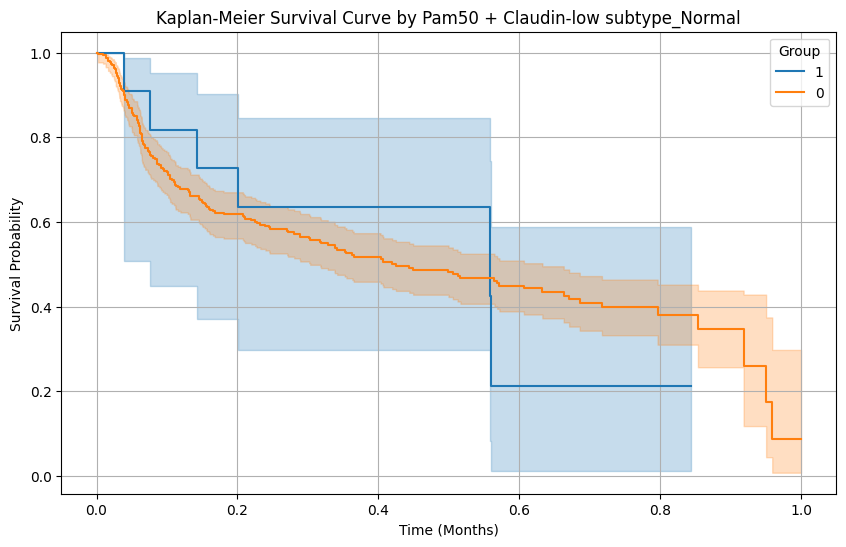

In [ ]:
# Plot Kaplan-Meier Curves
from lifelines import KaplanMeierFitter

# To get each seperate categorical column outcome
groups = tnbc_df['Pam50 + Claudin-low subtype_Normal'].unique()

kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves
plt.figure(figsize=(10, 6))
for group in groups:
    # Because you are using one-hot encoded column, it only contains 0 and 1
    # So the group_data needs to be selected using the original dataframe and the on-hot encoded column
    group_data = tnbc_df[tnbc_df['Pam50 + Claudin-low subtype_Normal'] == group]
    kmf.fit(group_data['Time-To-Event'], event_observed=group_data['Event'], label=group)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Pam50 + Claudin-low subtype_Normal')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title='Group')
plt.show()

In [ ]:
# Model creation time...
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Define your selected features and target column
selected_features = [
    'Age at Diagnosis',
    'Lymph nodes examined positive',
    'Nottingham prognostic index',
    'Tumor Size',
    'Tumor Stage',
    'Type of Breast Surgery_Mastectomy',
    'Pam50 + Claudin-low subtype_Her2',
    'Pam50 + Claudin-low subtype_claudin-low',
    'Overall Survival Status_Living',
    'Relapse Free Status_Recurred',
    '3-Gene classifier subtype_ER-/HER2-'
]

time_to_event_col = 'Time-To-Event'
event_col = 'Event'

# Split data into features (X) and targets (y)
X = tnbc_df[selected_features]
y_event = tnbc_df[event_col]
y_time_to_event = tnbc_df[time_to_event_col]

# Initial train-test split
X_train, X_test, y_event_train, y_event_test, y_time_train, y_time_test = train_test_split(
    X, y_event, y_time_to_event, test_size=0.2, random_state=42
)

# Further split training data into training and validation sets
X_train, X_val, y_event_train, y_event_val, y_time_train, y_time_val = train_test_split(
    X_train, y_event_train, y_time_train, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 (validation set)


# Normalize numerical features
numerical_features = [
    'Age at Diagnosis',
    'Lymph nodes examined positive',
    'Nottingham prognostic index',
    'Tumor Size',
    'Tumor Stage'
]
scaler = StandardScaler()

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# One-hot encode categorical features
categorical_features = [
    'Type of Breast Surgery_Mastectomy',
    'Pam50 + Claudin-low subtype_Her2',
    'Pam50 + Claudin-low subtype_claudin-low',
    'Overall Survival Status_Living',
    'Relapse Free Status_Recurred',
    '3-Gene classifier subtype_ER-/HER2-'
]

X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Ensure both training and testing datasets have the same columns after one-hot encoding
X_train, X_test = X_train.align(X_test, axis=1, fill_value=0)

# Verify the shapes of the datasets
print(f"Training set shape: {X_train.shape}, {y_event_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_event_test.shape}")

Training set shape: (192, 11), (192,)
Testing set shape: (64, 11), (64,)


In [ ]:
# Neural network time for the binary classification...

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(11,)),  # Input shape is equal to the number of features
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_event_train,
    validation_data=(X_val, y_event_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

print(classification_report(y_event_test, y_pred_class))
print("ROC-AUC:", roc_auc_score(y_event_test, y_pred))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - AUC: 0.5704 - accuracy: 0.5595 - loss: 0.7025 - val_AUC: 0.7099 - val_accuracy: 0.4375 - val_loss: 0.6979
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.6831 - accuracy: 0.6324 - loss: 0.6430 - val_AUC: 0.9104 - val_accuracy: 0.7969 - val_loss: 0.6405
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.6943 - accuracy: 0.6635 - loss: 0.6425 - val_AUC: 0.9635 - val_accuracy: 0.9375 - val_loss: 0.5880
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8550 - accuracy: 0.7892 - loss: 0.5708 - val_AUC: 0.9828 - val_accuracy: 0.9375 - val_loss: 0.5448
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8957 - accuracy: 0.8327 - loss: 0.5296 - val_AUC: 0.9906 - val_accuracy: 0.9375 - val_loss: 0.5030
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9371 - accuracy: 0.8283 - loss: 0.4862 - val_AUC: 0.9953 - val_accuracy: 0.9688 - val_loss: 0.4653
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9456 - accura

In [ ]:
# RNN for the time predictions...

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Tuple out of range, so reformat data
y_time_train = y_time_train.values.reshape(-1, 1, 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation="relu", input_shape=(y_time_train.shape[1], y_time_train.shape[2])))  # Adjust input shape
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_time_train, epochs=10, batch_size=32)

# Model evaluation
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_time_test, y_pred)
print(f"Mean Squared Error: {mse}") # 0.04 is a good enough MSE for me...

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2315
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0840 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0678  
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0427 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432  
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0427  
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0430 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0365 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0352 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0351 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Mean Squared Error: 0.0480431815044846
